# Hierarchical Models for Sports Analytics
## Using PyMC

Strengths of a Bayesian aproach that are relevant to data science:
* Great flexibility to quickly and iteratively build statistical models
* Offers principled way of dealing with uncertainty
* Don't just want most likely outcome but distribution of all possible outcomes
* Allows expert information to guide model by using informative priors
* Hierarchical modeling

In this tutorial you'll learn:
* How to go from math to model
* How to specify priors for your model
* How to evaluate a model
* How to iteratively improve a model

We will follow a **workflow** for iterative improvement of our model.

## Data organization

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor.tensor as pt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 42

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.15.1+18.g09ea8c83d


Let's query for some data for estimating home run rate, including some potential covariates/group indicators.

In [2]:
baseball_data = pl.read_csv('data/batter_data.csv')

fitting_subset = baseball_data.filter(pl.col("season") < 2023).with_columns(
    pl.concat_str([
        pl.col("name"),
        pl.col("season"),
        pl.col("team")
    ], separator=" - ").alias("label")
).drop_nulls()

Distribution of home run rates:

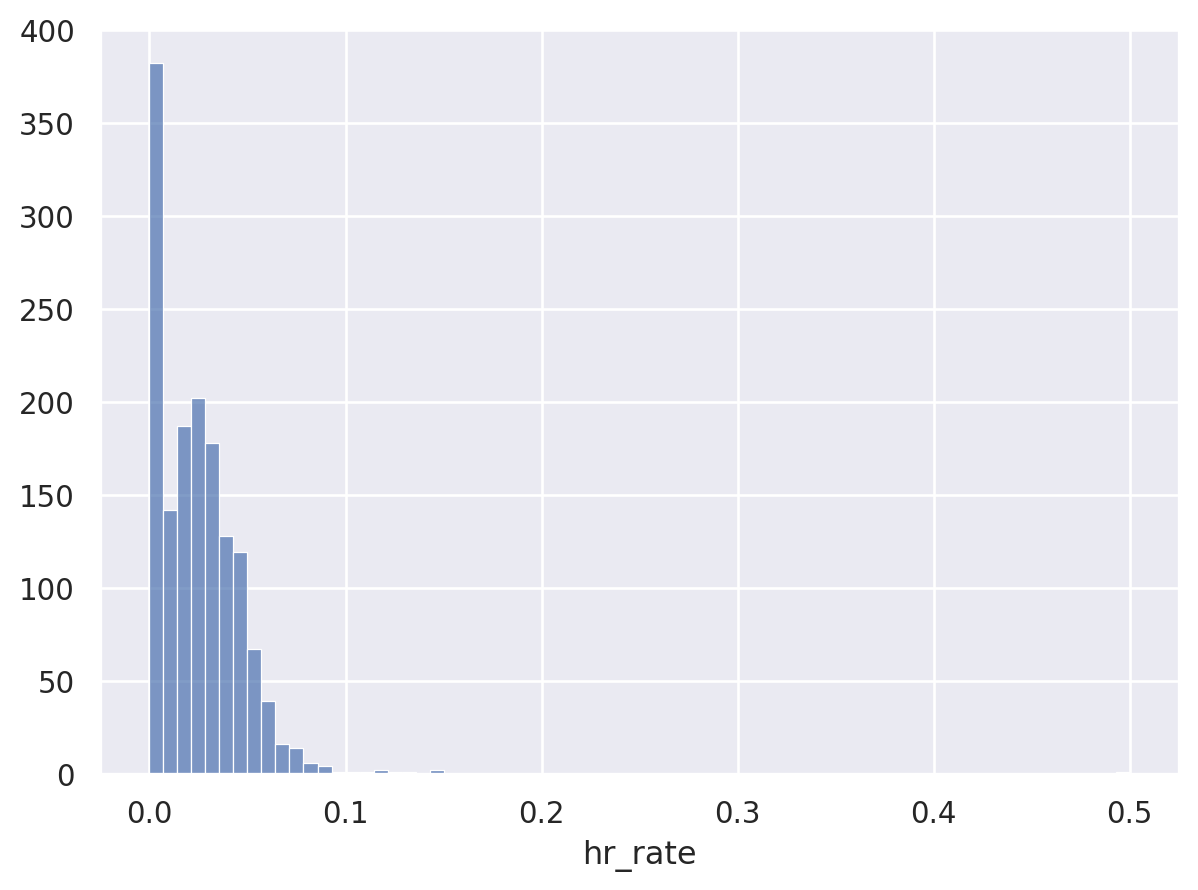

In [3]:
(so.Plot(
    fitting_subset.with_columns((pl.col("hr") / pl.col("num_pa")).alias("hr_rate")), 
    x="hr_rate")
.add(so.Bars(), so.Hist(bins=70)))

A natural likelihood function for this data is the binomial distribution. The binomial distribution is a discrete probability distribution that models the number of successes in a sequence of $n$ independent success/failure events, each of which yields success with probability $p$. Such a success/failure experiment is also called a **Bernoulli trial**; when $n = 1$, the binomial distribution is a Bernoulli distribution. 

$$y_i \sim \text{Binomial}(n_i, p_i)$$

## Choosing a prior



$$ p_i = \text{Uniform}(0, 1) $$

In [4]:
pa, hr = fitting_subset.select(['num_pa', 'hr']).cast(pl.Int32).to_numpy().T
coords = {'batter':fitting_subset.select('label').to_numpy().squeeze()}

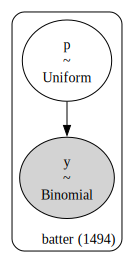

In [5]:
with pm.Model(coords=coords) as uninformative_prior_model:

    p = pm.Uniform('p', 0, 1, dims='batter')

    y = pm.Binomial('y', n=pa, p=p, observed=hr, dims='batter')

pm.model_to_graphviz(uninformative_prior_model)

## Prior Predictive Sampling

Before attempting to fit this model, let's take a look at this (admittedly simple) model and see what it implications are before any data are brought to bear on the problem. To do this, we can generate data from the **prior predictive distribution**. This is a good idea to do before fitting any model, as it allows us to check that our model is reasonable and that our inference algorithms are working.

$$
p\left(y\right)=\int_{\Theta} p\left(y, \theta\right) \mathrm{d} \theta=\int_{\Theta} p\left(y \mid \theta\right) p(\theta) \mathrm{d} \theta
$$

This distribution is predictive in the sense that its predicting the behavior of new data that is not currently part of the model.

Notice we are not conditioning on any data here! We are seeing what the model predicts in the absence of data.

Sampling from the prior predictive distribution is easy: we draw a value for $p$ from the prior distribution, and then sample a value for $y$ from the binomial distribution conditional on the drawn value of $p$. We can repeat this process as many times as we need to generate a sample from the prior predictive distribution.

In PyMC, this is:

In [6]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


The prior predictive sampler (like all samplers in PyMC), yeilds a custom data structure upon completion, an `InferenceData` object from the ArviZ library. This object contains the samples from the prior predictive distribution, as well as some metadata about the model and the sampling process.

In [7]:
uninformed_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Let's look at the distribution of home run rates, which unsurprisingly are uniformly distributed between 0 and 1.

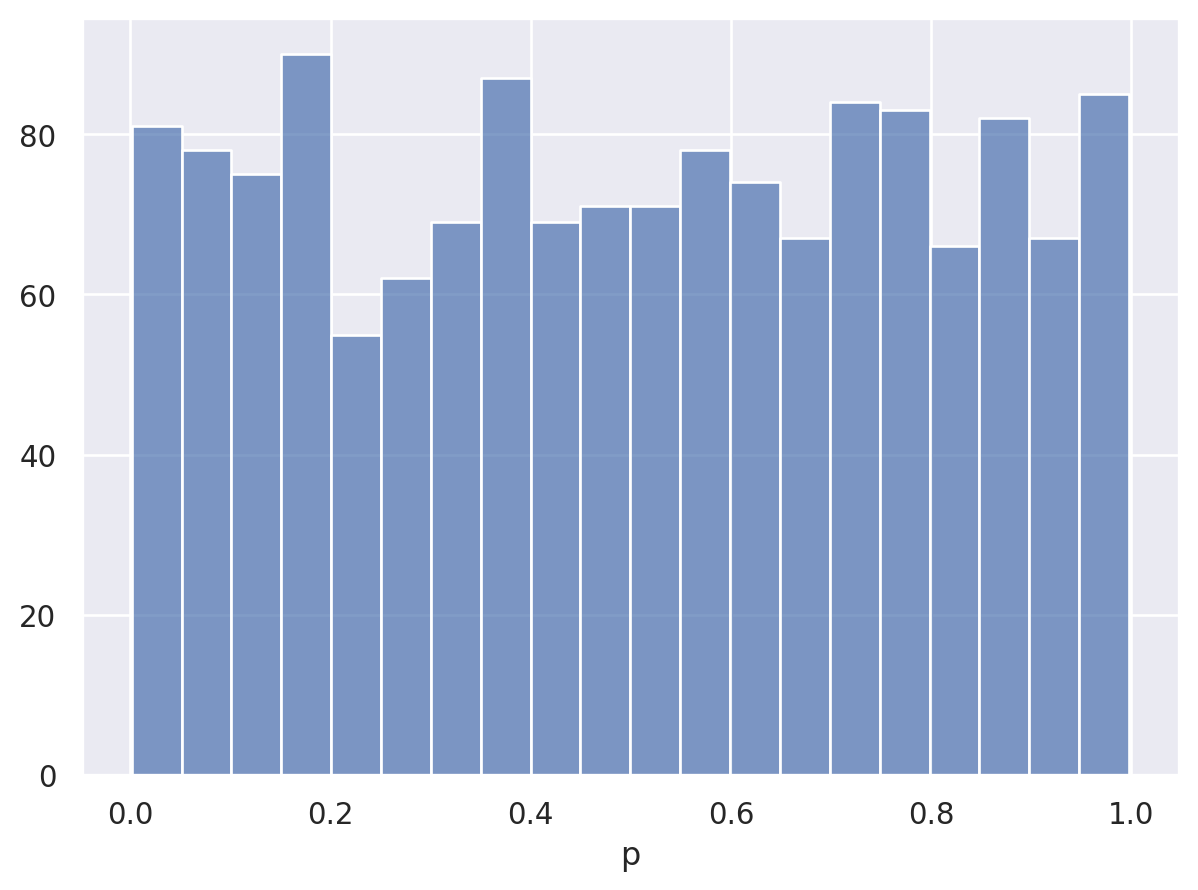

In [8]:
so.Plot(uninformed_prior_trace.prior['p'].sel(chain=[0], draw=[0]).squeeze()).add(so.Bars(), so.Hist(bins=20))

The posterior predictive samples are simulated home runs for each player in the dataset, given the number of plate appearances passed to the binomial sampling distribution. Right away, it is apparent that the model behaves poorly out of the box, but remember it has not yet been exposed to any of the data.

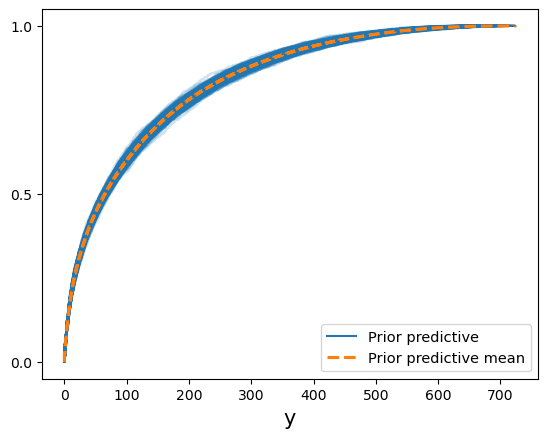

In [9]:
az.plot_ppc(uninformed_prior_trace, group='prior', kind='cumulative');

## Model Fitting with MCMC

Let's go ahead and estimate our model using Markov chaine Monte Carlo (MCMC); specifically, PyMC will use the NUTS algorithm since all of our parameters are continuous.

How many samples do we need? How long should we tune?

In [10]:
with uninformative_prior_model:
    trace = pm.sample(draws=100, tune=100, cores=4, chains=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Notice that we have been issued a couple of warnings, one regarding the size of **rhat** statistics and another regarding the effective sample size. These are both **convergence diagnostics** that are used to assess whether the MCMC algorithm has converged to the target distribution.

### $\hat{R}$ Diagnostic

The R-hat diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

It calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, the Gelman-Rubin statistic monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. 

In ArviZ, the function
`rhat` will calculate $\hat{R}$ for each stochastic node in
the passed model. Specifically, it calulates split-$\hat{R}$, which compares the first half to the second half of each chain, to allow for within-chain detection of lack of convergence.

In [11]:
az.summary(trace).sort_values('r_hat', ascending=False).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[Javier Baez - 2021 - CHC],0.063,0.012,0.042,0.087,0.001,0.0,386.0,241.0,1.07
p[Luis Gonzalez - 2022 - SF],0.014,0.007,0.004,0.027,0.000,0.0,322.0,103.0,1.07
p[Jon Berti - 2021 - MIA],0.019,0.008,0.004,0.032,0.001,0.0,269.0,242.0,1.06
p[Stephen Piscotty - 2021 - OAK],0.033,0.013,0.011,0.056,0.001,0.0,451.0,48.0,1.06
p[Wilmer Flores - 2021 - SF],0.043,0.010,0.025,0.063,0.000,0.0,376.0,259.0,1.06


Bulk-ESS is useful as a diagnostic for the sampling efficiency in the bulk of the posterior. It is defined as the effective sample size for rank normalized values using split chains. 

Tail-ESS is useful as a diagnostic for the sampling efficiency in the tails of the posterior. It is defined as the minimum of the effective sample sizes for 5% and 95% quantiles.

---

Clearly, 100 samples after 100 tuning samples is not sufficient to estimate the posterior distribution. Let's bump things up.

In [12]:
with uninformative_prior_model:
    trace = pm.sample(draws=1000, tune=1000, cores=4, chains=4, random_seed=RANDOM_SEED)

# Add samples to the InfrernceData object
uninformed_prior_trace.extend(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


<Axes: title={'center': 'p\nMookie Betts - 2022 - LAD'}, xlabel='Total number of draws', ylabel='ESS'>

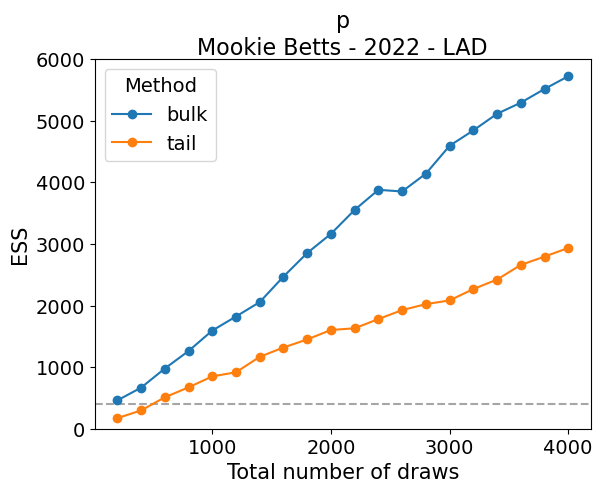

In [13]:
az.plot_ess(uninformed_prior_trace, var_names=["p"], coords={'batter': ['Mookie Betts - 2022 - LAD']}, kind="evolution")

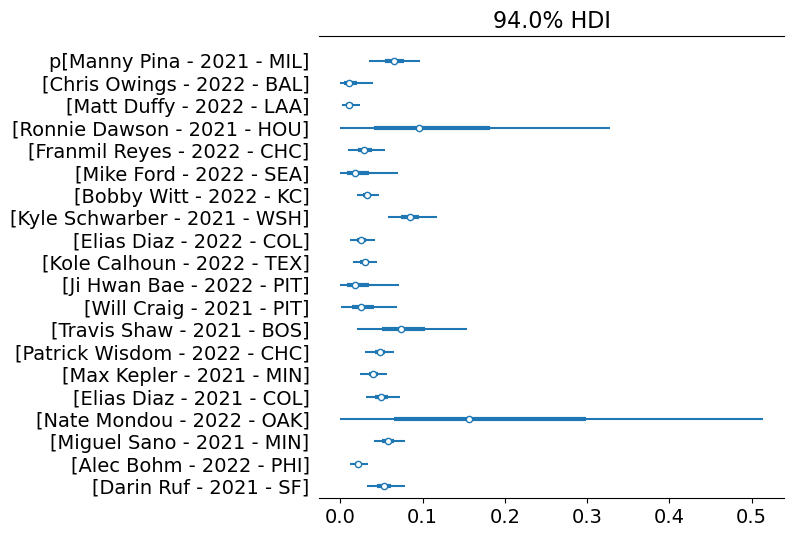

In [14]:
SAMPLE_BATTERS, obs_rates = fitting_subset.sample(n=20, seed=2766069).with_columns((pl.col("hr") / pl.col("num_pa")).alias("hr_rate")).select("label", "hr_rate").to_numpy().T

(ax,) = az.plot_forest(uninformed_prior_trace, coords={'batter': list(SAMPLE_BATTERS)}, combined=True)

Sampling was good for all players, but you can see that some are far more uncertain than others, and this uncertainty is related to the number of plate appearances, as we would expect. 

To identify batters with high home run rates, we can plot the ordered mean estimates, as well as their 94% HPD:

In [15]:
uninformed_means = uninformed_prior_trace.posterior.mean(dim=("chain", "draw"))
uninformed_hdi = az.hdi(uninformed_prior_trace)

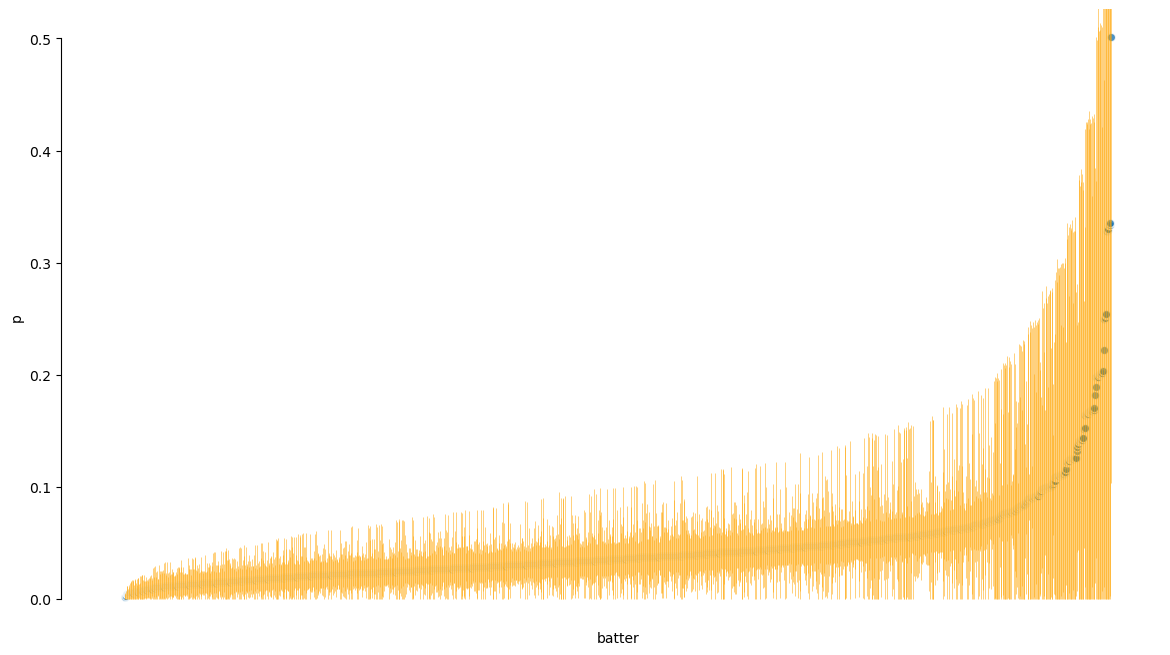

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))

uninformed_means_iter = uninformed_means.sortby("p")
uninformed_hdi_iter = uninformed_hdi.sortby(uninformed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    uninformed_hdi_iter.p.sel(hdi="lower"),
    uninformed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=0.6
)
uninformed_means_iter.plot.scatter(x="batter", y="p", ax=ax, alpha=0.8)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10, trim=True, bottom=True);

Of concern here is the tail of high home run rates; there are a lot of them, and they are all highly uncertain. If we plot the interval width against the number of plate appearances, we can see that sampling error is indeed a big factor.

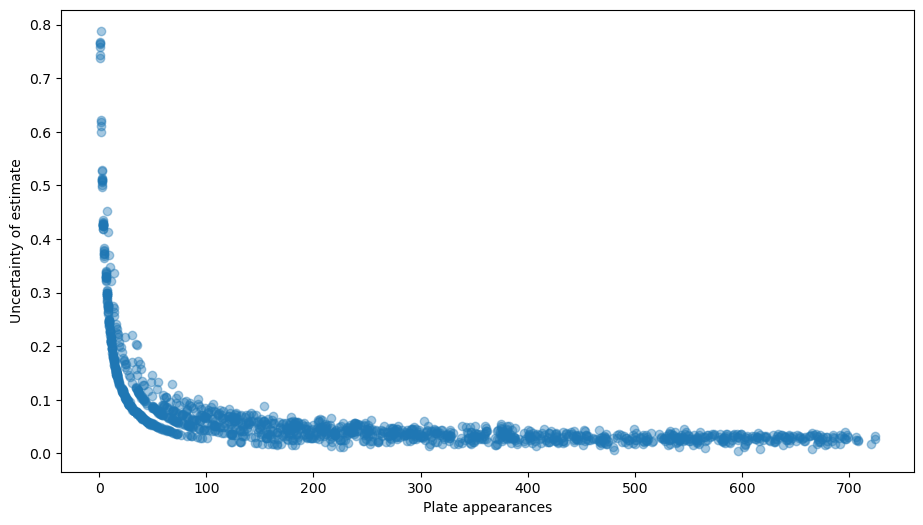

In [17]:
uncertainty = uninformed_hdi.p.sel(hdi="higher") - uninformed_hdi.p.sel(hdi="lower")

plt.figure(figsize=(11, 6))
plt.plot(pa, uncertainty, "o", alpha=0.4)
plt.xlabel("Plate appearances")
plt.ylabel("Uncertainty of estimate");

This is a classic issue with no-pooling models: when you estimate individuals as being independent from each other, how do you interpret the small-sample-size estimates?

Let's look closer at a handful of random examples from the dataset. Below are the posterior distributions of rates for 20 batters (blue intervals), along with the empirical rates (red dots). 

This illustrates how the Bayesian posterior is a (weighted) compromise between the prior (uniform over the [0,1] interval) and the data (observed home runs and plate appearances).

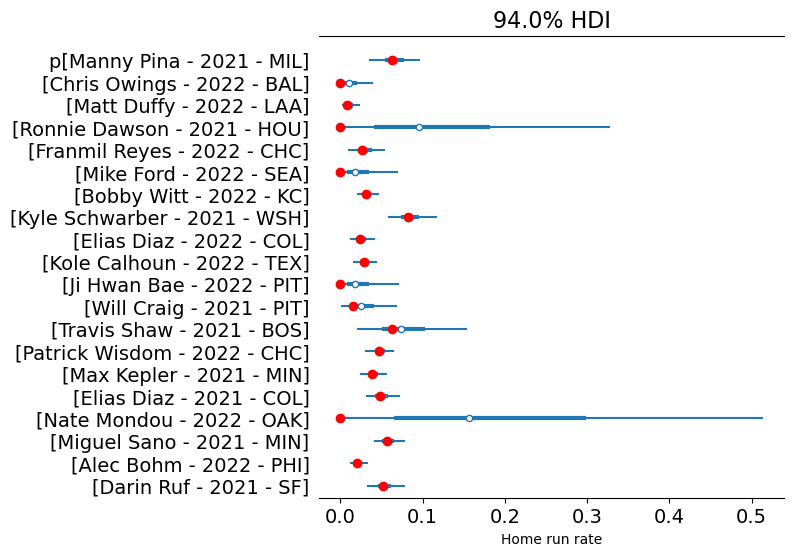

In [18]:
(ax,) = az.plot_forest(uninformed_prior_trace, coords={'batter': SAMPLE_BATTERS}, combined=True)
ax.plot(obs_rates[::-1], ax.get_yticks(), 'ro')
ax.set_xlabel("Home run rate");

Note that all of the empirical rates lie within the posterior interval of the estaimtes, however wide or narrow they end up being.

## Posterior Predictive Sampling

We can also use the posterior distribution to generate predictions for new data. This is is done via the **posterior predictive distribution**, which is a distribution over new data, conditional on the observed data. 

$$
p\left(y^{\mathrm{new}} \mid y^{\mathrm{obs}}\right)=\int p\left(y^{\mathrm{new}} \mid \theta\right) p(\theta \mid y^{\mathrm{obs}}) \mathrm{d} \theta
$$

This will give us an idea about absolute model performance after it has been updated with data. It essentially sinulates new datasets, which can then be compared to the dataset that was actually observed.

In [19]:
with uninformative_prior_model:
    pm.sample_posterior_predictive(uninformed_prior_trace, extend_inferencedata=True)

Sampling: [y]


Output()

We can use `plot_ppc` again, but this time with the \"posterior\" group.

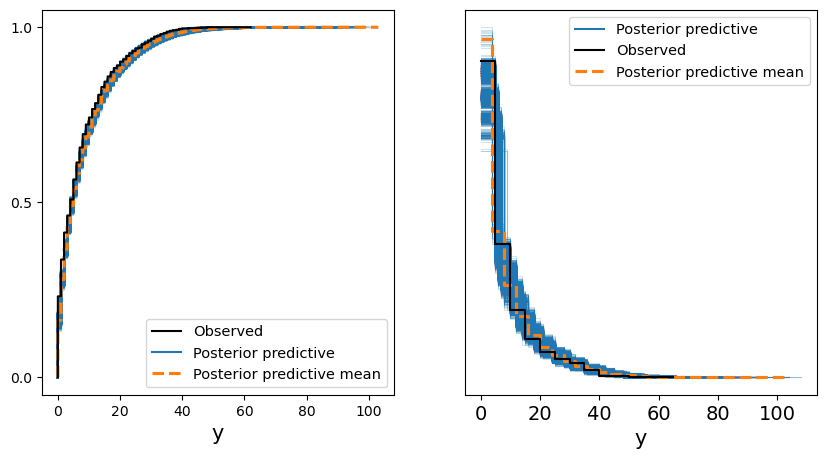

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(uninformed_prior_trace, group='posterior', kind='cumulative', ax=axes[0]);
az.plot_ppc(uninformed_prior_trace, group='posterior', ax=axes[1]);

The model fits the dataset reasonably well, though the estiamtes for low-sample size home run rates are not great.

## Informative Priors

An advantage of using Bayesian models is the ability to incorporate prior information into the model. This is especially useful when data are sparse, as with batters having few plate appearances. In order to implement an informative prior here, we need to move away from the uniform prior on $p$ and choose a different distribution. An obvious choice is the **beta distribution**, which is a continuous distribution on the interval [0,1] that is parameterized by two positive shape parameters, $\alpha$ and $\beta$. The beta distribution is a conjugate prior for the binomial distribution, which means that the posterior distribution will be a beta distribution as well.

$$ p(x \mid \alpha, \beta) =
            \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)} $$

The two shape parameters make the beta distribtion pretty flexible:

![](https://www.pymc.io/projects/docs/en/stable/_downloads/fc694eda09419e702a96ca1c2031e2a6/pymc-Beta-1.png)

The trick is to choose the right shape parameters to encode our prior information, which may not be intuitive. We can try a few different values and see what happens.

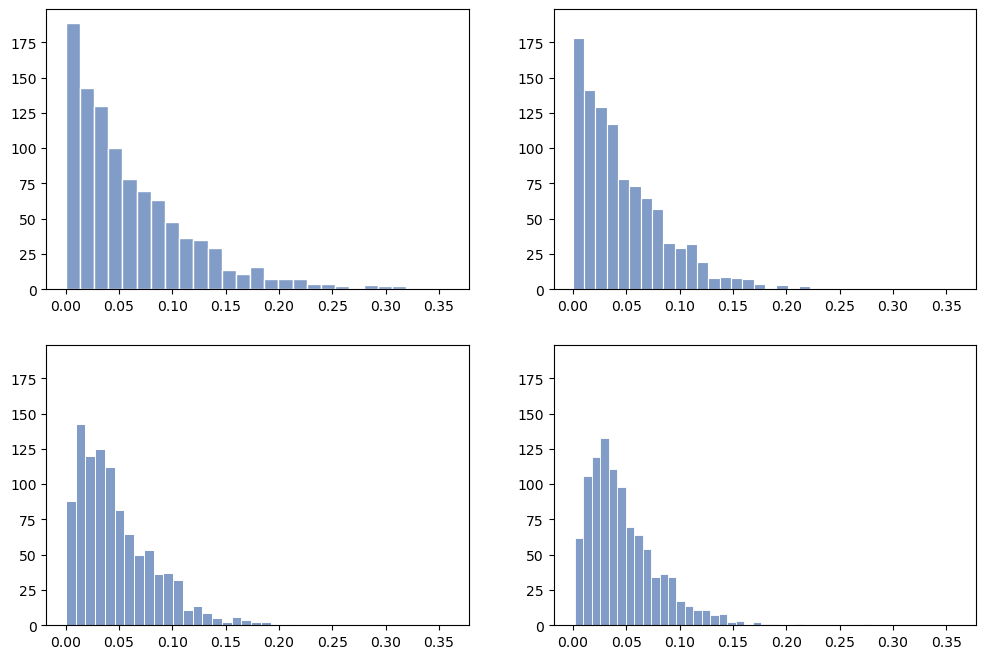

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for params, ax in zip([(1, 15), (1, 20), (1.5, 30), (2, 40)], axes.flat):
    so.Plot(pm.Beta.dist(*params, shape=1000).eval()).add(so.Bars(), so.Hist()).on(ax).plot()

In PyMC, it is helpful to use the `find_constrained_prior` function to choose appropriate hyperparameters for a given distribution. For exmaple, we might be interested in a beta distribtion with 95% of its probability mass between 0.01 and 0.11. This information is used to optimize the shape parameters of the beta distribution.

In [22]:
pm.find_constrained_prior(
    pm.Beta,
    lower=0.01,
    upper=0.11,
    init_guess={"alpha": 2, "beta": 40},
)

{'alpha': 3.1375906600927, 'beta': 60.555650325086816}

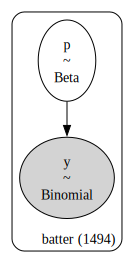

In [23]:
with pm.Model(coords=coords) as informative_prior_model:

    beta_params = pm.find_constrained_prior(
        pm.Beta,
        lower=0.005,
        upper=0.09,
        init_guess={"alpha": 2, "beta": 40},
    )

    p = pm.Beta('p', **beta_params, dims='batter')

    y = pm.Binomial('y', n=pa, p=p, observed=hr, dims='batter')

pm.model_to_graphviz(informative_prior_model)

> ### Empirical Bayes
> One way to obtain informative priors is to derive a distribution from **population data**. This is not “purely” Bayesian, since in a sense we are using the data to determine the prior specification. Furthermore, the estimation of ψ must be done with non-Bayesian techniques. The resulting prior is thought to represent the population of all possible values of the unknown parameter, and is called an **empirical Bayes** prior.

In [24]:
with informative_prior_model:
    informed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


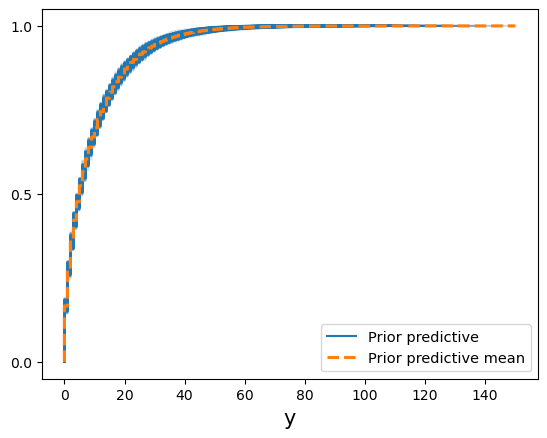

In [25]:
az.plot_ppc(informed_prior_trace, group='prior', kind='cumulative');

In [26]:
with informative_prior_model:
    informed_prior_trace.extend(pm.sample(cores=4, chains=4, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [27]:
informed_means = informed_prior_trace.posterior.mean(dim=("chain", "draw"))
informed_hdi = az.hdi(informed_prior_trace)

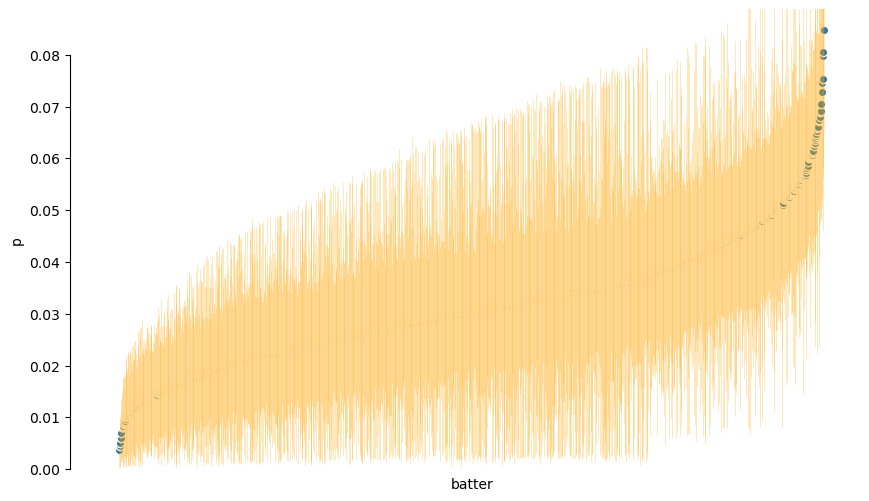

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

informed_means_iter = informed_means.sortby("p")
informed_hdi_iter = informed_hdi.sortby(informed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    informed_hdi_iter.p.sel(hdi="lower"),
    informed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.3,
    linewidth=0.6
)
informed_means_iter.plot.scatter(x="batter", y="p", ax=ax)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10, trim=True, bottom=True);

One thing that you may have noticed is that we treat every player-season as independent. However, repeated measures of individual players are **correlated**. We can improve our model to account for this.

## Multilevel/Hierarchical models

When we analyze data unpooled, we imply that they are sampled independently, from separate models. This approach claims that differences between players are too severe to combine them -- we assume that batters are unrelated:

![](images/unpooled_model.png)

 In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different nor exactly the same. This is ***partial pooling***:

 ![](images/partial_pooled_model.png)

 We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for estimating home run rate is one where we allow individual rates to vary, but constrained by a *population model*. A partial pooling model is essentially a weighted average (based on sample size) of a pooled (population mean) and unpooled model.

You don't have to be Bayesian to do this!

$$\hat{p} \approx \frac{(n_j/\sigma_p^2)\bar{p}_j + (1/\sigma^2)\bar{p}}{(n_j/\sigma_p^2) + (1/\sigma^2)}$$

/tmp/ipykernel_795534/1232772289.py:7: RuntimeWarning: divide by zero encountered in divide
  partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1/var_rates + 1/pop_var)
/tmp/ipykernel_795534/1232772289.py:7: RuntimeWarning: invalid value encountered in multiply
  partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1/var_rates + 1/pop_var)


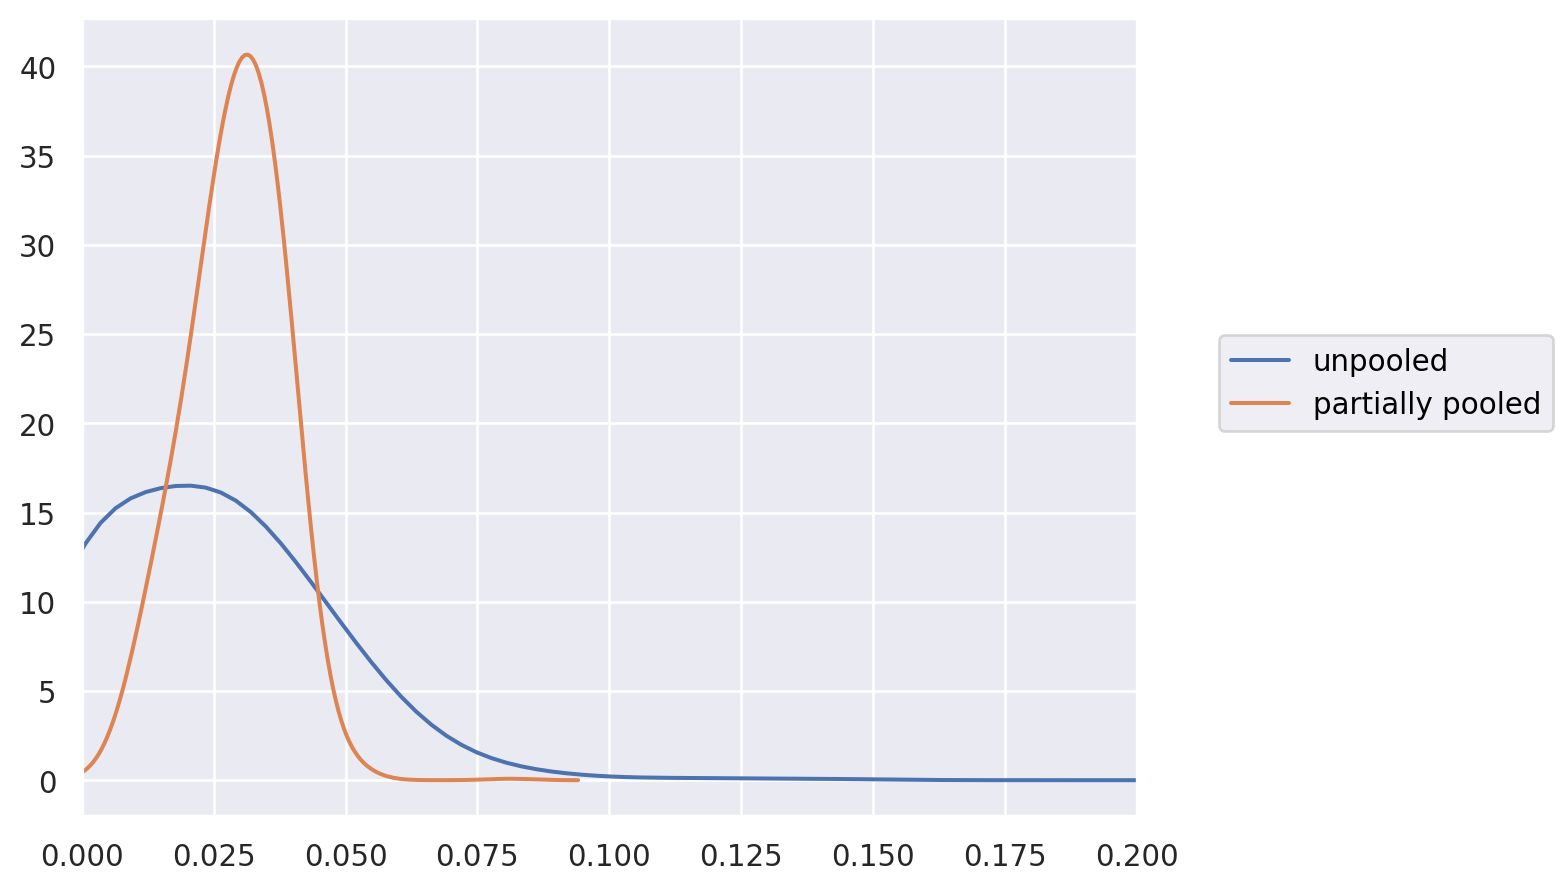

In [29]:
rates = hr / pa
var_rates = rates * (1 - rates) 

pop_rate = (fitting_subset.select(pl.col("hr")).sum() / fitting_subset.select(pl.col("num_pa")).sum()).to_numpy().item()
pop_var = pop_rate * (1 - pop_rate) 

partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1/var_rates + 1/pop_var)

(
    so.Plot()
    .add(so.Line(color="C0"), so.KDE(bw_adjust=2), x=rates, label="unpooled")
    .add(so.Line(color="C1"), so.KDE(bw_adjust=2), x=partial_pooled_rates, label="partially pooled")
    .limit(x=(0, 0.2))
)

To build a Bayesian hierarchical model, we need to move from simply specifying a prior on the latent home run rates to constructing a **population model** for them. For example, we can hypothesize that MLB home run rates are distributed as a beta distribution, with unknown shape parameters $\alpha$ and $\beta$.

$$ p_i \sim \text{Beta}(\alpha, \beta) $$
$$ \alpha, \beta \sim p() $$

The model will then seek to estimate $\alpha$ and $\beta$ from the data. These estimates will be more strongly influenced by batters with more plate appearances, and will shrink hitters with fewer plate appearances toward the population mean.

> How do we choose priors for $\alpha$ and $\beta$?

A natural choice is the **gamma distribution**. The gamma distribution is a continuous distribution that is defined for all positive values of $x$, and is parameterized by shape $\alpha$ and scale $\beta$.

$$ f(x \mid \alpha, \beta) =
            \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}
$$

![](https://www.pymc.io/projects/docs/en/stable/_downloads/b66a9582ce2b1beb39697efd31ee89da/pymc-Gamma-1.png)

Rather than assuming each observation is independent, we will hypothesize a latent home run rate for each player (ignoring temporal dynamics for now). Therefore we will need to have a unique index for each batter that can be used to look up individual latent home run rates, and use it for each year that a given player appears in the dataset.

In [30]:
def factorize(dataset, col_name):
    dataset = dataset.with_columns(pl.col(col_name).cast(pl.Categorical).to_physical().alias("idx"))
    categories = dataset.select([col_name, "idx"]).unique().sort("idx").select(col_name).to_numpy().squeeze()
    idx = dataset.select("idx").to_numpy().squeeze()

    return idx, categories

batter_idx, batters = factorize(fitting_subset, "name")
obs_idx, observations = factorize(fitting_subset, "label")

coords = {'batter': batters, 'obs': observations}

We can start by specifying our home run rate population model:

In [31]:
with pm.Model(coords=coords) as beta_partial_pooling_model:

    alpha_params = pm.find_constrained_prior(
        pm.Gamma,
        lower=0.05,
        upper=2,
        init_guess={"alpha": 2, "beta": 1},
    )
    alpha = pm.Gamma("alpha", **alpha_params)

    beta_params = pm.find_constrained_prior(
        pm.Gamma,
        lower=8,
        upper=12,
        init_guess={"alpha": 10, "beta": 1},
    )
    beta = pm.Gamma("beta", **beta_params)

And the rest of the model is the same as the non-hierarchical version. Note that now, however, we have latent paramters for the beta distribution, and not just constants.

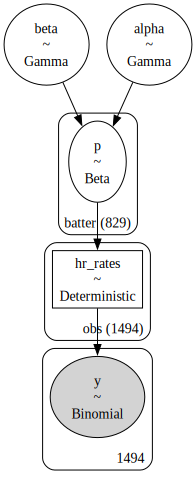

In [32]:
with beta_partial_pooling_model:

    p = pm.Beta("p", alpha, beta, dims='batter')

    hr_rates = pm.Deterministic("hr_rates", p[batter_idx], dims='obs')

    y = pm.Binomial('y', n=pa, p=hr_rates, observed=hr)

pm.model_to_graphviz(beta_partial_pooling_model)

The prior predictive sample checks out:

Sampling: [alpha, beta, p, y]


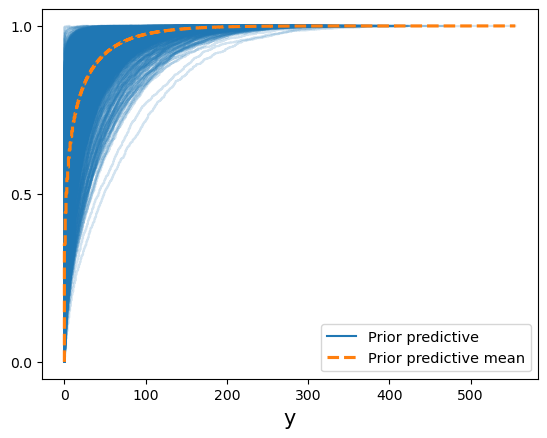

In [33]:
with beta_partial_pooling_model:
    beta_partial_pooling_trace = pm.sample_prior_predictive(1000)

az.plot_ppc(beta_partial_pooling_trace, group='prior', kind='cumulative');

In [34]:
with beta_partial_pooling_model:
    beta_partial_pooling_trace.extend(pm.sample(chains=4, cores=4, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [35]:
with beta_partial_pooling_model:
    pm.sample_posterior_predictive(beta_partial_pooling_trace, extend_inferencedata=True)

Sampling: [y]


Output()

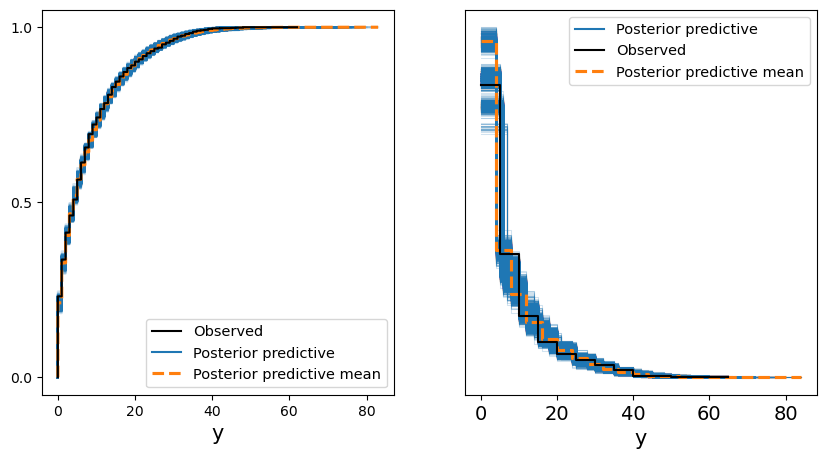

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(beta_partial_pooling_trace, group='posterior', kind='cumulative', ax=axes[0]);
az.plot_ppc(beta_partial_pooling_trace, group='posterior', ax=axes[1]);

Let's do a quick comparison between the non-hierarchical and hierarchical models:

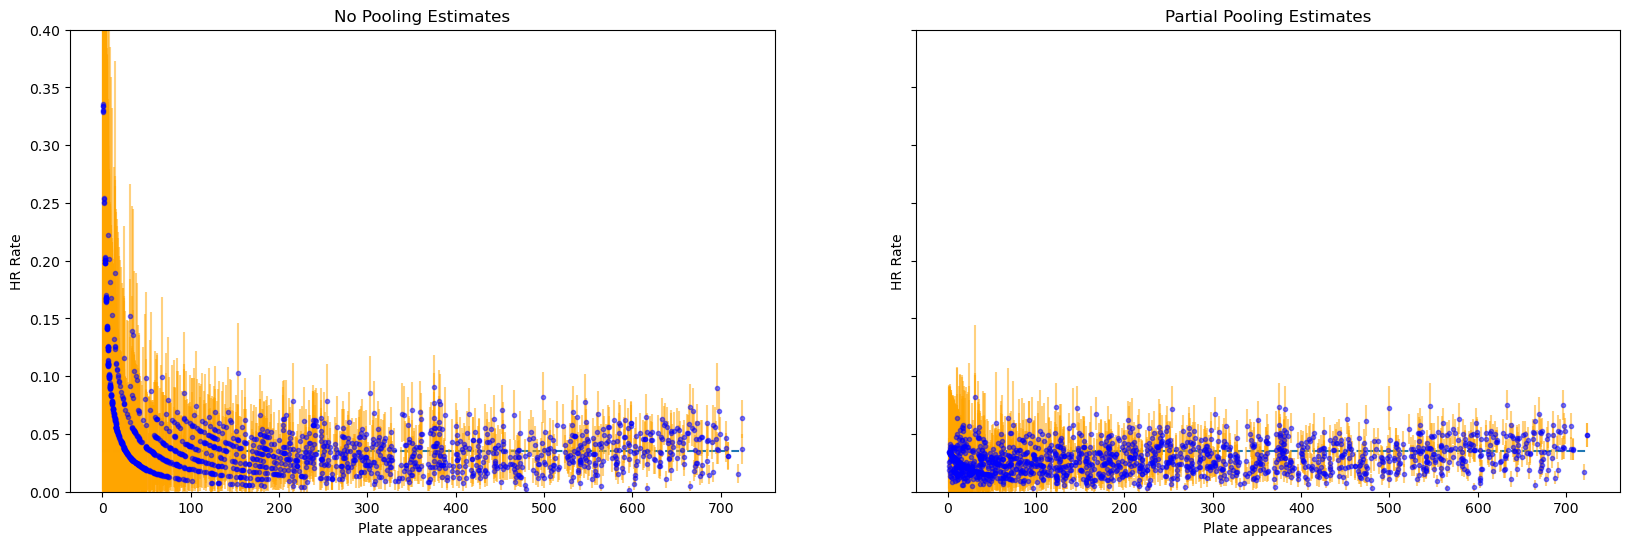

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)

N_pa = fitting_subset.select(pl.col("num_pa")).to_numpy().squeeze()
for ax, trace, level, idx in zip(
    axes,
    (uninformed_prior_trace, beta_partial_pooling_trace),
    ("no pooling", "partial pooling"),
    (slice(0, len(N_pa)), batter_idx)
):

    alpha = beta_partial_pooling_trace.posterior.alpha.mean()
    beta = beta_partial_pooling_trace.posterior.beta.mean()
    ax.hlines(
        alpha / (alpha + beta),
        0.,
        N_pa.max() + 1,
        # alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).p[idx]
    ax.vlines(N_pa, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    # plot means
    ax.plot(
        N_pa,
        trace.posterior.mean(dim=("chain", "draw")).p[idx], 
        'b.', alpha=0.5
    )

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Plate appearances",
        # xscale="log",
        ylabel="HR Rate",
        ylim=(0., 0.4)
    )

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former are both more extreme and more imprecise. Indeed, in the partially-pooled model, estimates in small-sample-size counties are informed by the population parameters -- hence more precise estimates. Moreover, the smaller the sample size, the more regression towards the overall mean (the dashed gray line) -- hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in counties where data is sparse. 

Notice also how the right side of the plot has not changed much (since they are driving the mean, rather than being shrunk towards it).

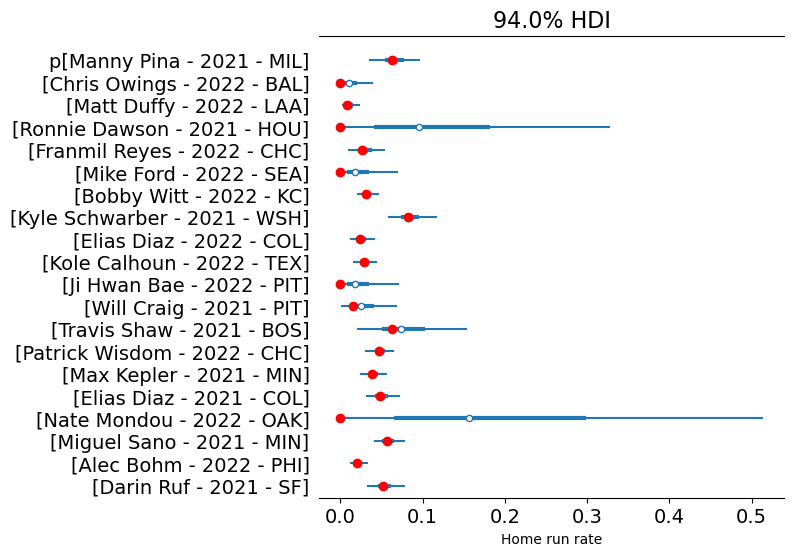

In [38]:
(ax,) = az.plot_forest(uninformed_prior_trace, coords={'batter': list(SAMPLE_BATTERS)}, combined=True)
ax.plot(obs_rates[::-1], ax.get_yticks(), 'ro')
ax.set_xlabel("Home run rate");
xlim = ax.get_xlim();

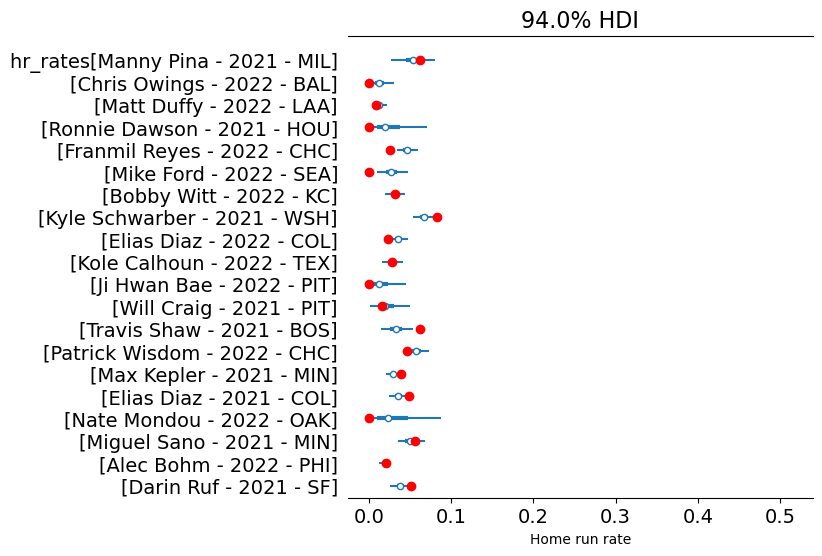

In [39]:
(ax,) = az.plot_forest(beta_partial_pooling_trace.posterior['hr_rates'], coords={'obs': SAMPLE_BATTERS}, combined=True)
ax.plot(obs_rates[::-1], ax.get_yticks(), 'ro')
ax.set_xlabel("Home run rate")
ax.set_xlim(xlim);

## Group covariate model

Our first partial pooling model is a simple hierarchical random effect. This means that the parameters in our model (hr rates) are functions of other parameters (the population mean and variance). So we are modeling rates as a distribtion, from which the home-run-hitting talents of each player are drawn. 

But its possible that we can do better than simply specifying a single distribtion to accound for all of the variability in the population. What if the population is *heterogeneous*, and we have additional data that can be used to describe this heterogeneity. We can use this data to create a hierarchical relationship that is more than just a univariate distribtion, but an entire regression model.

For example, knowing which primary position a batter plays may provide information on their home run rate, perhaps related to the characteristics of their home park. Or the primary position of the batter may be informative--first basemen tend to hit more home runs than second basemen, for example.

We can expand our model of home run rates with covariates like this:

$$\text{logit}(p_i) \sim N(\theta_i, \sigma^2)$$

where

$$\theta_i = \mu_{j[i]} + \epsilon_{i}$$

and

$$\mu_j \sim N(m_{\mu}, s_{\mu}), \epsilon_i \sim N(0, \sigma)$$

Here, $j[i]$ signifies the mean $\mu_j$ that corresponds to the group (position) to which batter $i$ belongs. While one could fit separate models for each group, this model fits a joint population mean $\mu$ but allows each group to vary from it in some way.

There is also a random effect $\epsilon_i$ corresponding to each individual batter, conditional on this mean.

This model is implemented in PyMC as:

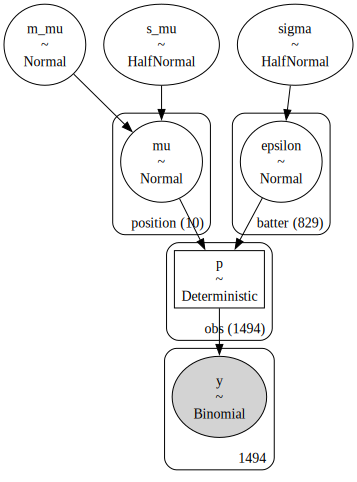

In [40]:
position_idx, positions = factorize(fitting_subset, "position")

coords['position'] = positions

with pm.Model(coords=coords) as position_means_model:

    # Group means
    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    mu = pm.Normal('mu', mu=m_mu, sigma=s_mu, dims='position')

    # Individual random effects
    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims='batter')

    p = pm.Deterministic('p', pm.math.invlogit(mu[position_idx] + epsilon[batter_idx]), dims='obs')

    y = pm.Binomial('y', n=pa, p=p, observed=hr)

pm.model_to_graphviz(position_means_model)

In [41]:
with position_means_model:
    position_means_trace = pm.sample(1000, tune=2000, chains=4, cores=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_mu, s_mu, mu, sigma, epsilon]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.


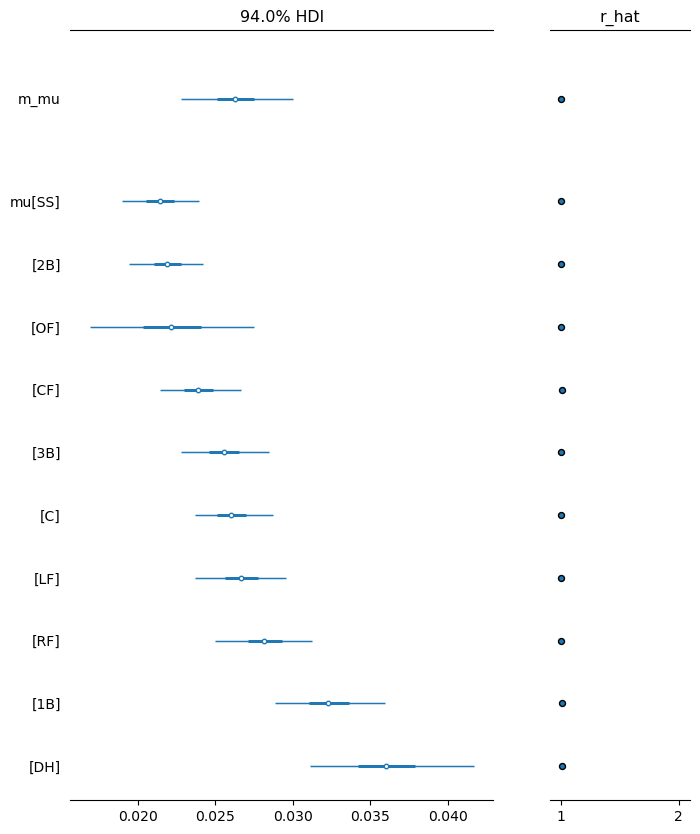

In [42]:
position_means = position_means_trace.posterior["mu"].mean(("chain", "draw"))
sorted_positions = position_means_trace.posterior["position"].sortby(position_means)

az.plot_forest(
    position_means_trace, 
    var_names=["m_mu", "mu"], 
    r_hat=True, 
    combined=True, 
    figsize=(8, 10), 
    textsize=10,
    coords={"position": sorted_positions},
    transform=lambda x: 1 / (1 + np.exp(-x)),
);

## Park Effects Model

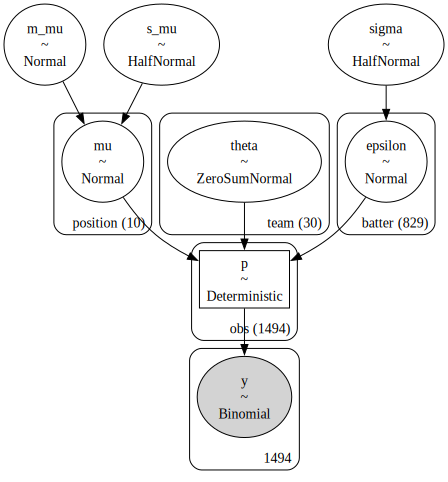

In [43]:
team_idx, teams = factorize(fitting_subset, "team")

coords['team'] = teams

with pm.Model(coords=coords) as team_model:

    # Group means
    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    mu = pm.Normal('mu', mu=m_mu, sigma=s_mu, dims='position')

    theta = pm.ZeroSumNormal('theta', sigma=1, dims='team')

    # Individual random effects
    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims='batter')

    p = pm.Deterministic('p', pm.math.invlogit(mu[position_idx] + theta[team_idx] + epsilon[batter_idx]), dims='obs')

    y = pm.Binomial('y', n=pa, p=p, observed=hr)

pm.model_to_graphviz(team_model)

In [44]:
with team_model:
    team_trace = pm.sample(1000, tune=2000, chains=4, cores=4, target_accept=0.9, nuts_sampler='numpyro', random_seed=RANDOM_SEED)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

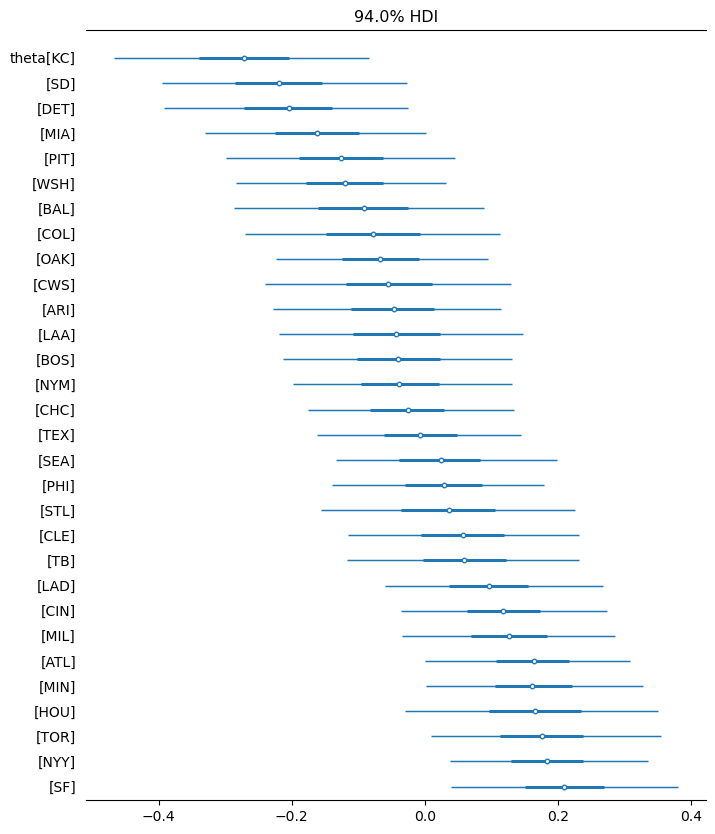

In [45]:
team_means = team_trace.posterior["theta"].mean(("chain", "draw"))
sorted_teams = team_trace.posterior["team"].sortby(team_means)

az.plot_forest(
    team_trace, 
    var_names=["theta"], 
    r_hat=False, 
    combined=True, 
    figsize=(8, 10), 
    textsize=10,
    coords={"team": sorted_teams},
);

### Model Comparison via Expected Log Predictive Density (ELPD)

The expected log pointwise predictive density (ELPD) is a Bayesian information criterion that can be used to compare non-nested models. It is based on the log pointwise predictive density (LPD), which is the log predictive density of each data point given the rest of the data and the model. 

The LPD is a sum of the log predictive density of each data point, and is therefore sensitive to the number of data points. The ELPD is the expected value of the LPD, and is therefore insensitive to the number of data points. 

The ELPD is computed by taking the log predictive density of each data point, and weighting it by the posterior probability of the model given the data. The ELPD is therefore a better measure of predictive accuracy than the LPD.

$$
\operatorname{ELPD}=\sum_{i=1}^N \int \mathrm{d} y^{new}_i f^*\left(y^{new}_i\right) \ln f\left(y^{new}_i \mid y^{obs}\right)
$$

Unfortunately, since $f^*\left(y^{new}_i\right)$ (the **true** model) is not known we cannot calculate ELPD directly (just as we typically cannot calculate KL distance directly). We are therefore forced to derive approximations of ELPD based on data sampled from the model.

#### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. 

The estimate of out-of-sample predictive fit from applying LOO cross-validation to a Bayesian model is:

$$lppd_{loo} = \sum_{i=1}^N \log p_{post(-i)}(y_i) =  \sum_{i=1}^N \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i| \theta^{(is)})\right)$$

so, each prediction is conditioned on $N-1$ data points, which induces an underestimation of the predictive fit for smaller $N$. The resulting estimate of effective samples size is:

$$p_{loo} = lppd - lppd_{loo}$$

As mentioned, using cross-validation for a Bayesian model, fitting $N$ copies of the model under different subsets of the data is computationally expensive. However, Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

This involves estimating the importance sampling LOO predictive distribution

$$p(\tilde{y}_i | y_{-i}) \approx \frac{\sum_{s=1}^S w_i(\theta^{(s)}) p(\tilde{y}_i|\theta^{(s)})}{\sum_{s=1}^S w_i(\theta^{(s)})}$$

where the importance weights are:

$$w_i(\theta^{(s)}) = \frac{1}{p(y_i | \theta^{(s)})} \propto \frac{p(\theta^{(s)}|y_{-i})}{p(\theta^{(s)}|y)}$$

The predictive distribution evaluated at the held-out point is then:

$$p(y_i | y_{-i}) \approx \frac{1}{\frac{1}{S} \sum_{s=1}^S \frac{1}{p(y_i | \theta^{(s)})}}$$

However, the posterior is likely to have a smaller variance and thinner tails than the LOO posteriors, so this approximation induces instability due to the fact that the importance ratios can have high or infinite variance.
To deal with this instability, a generalized Pareto distribution fit to the upper tail of the distribution of the importance ratios can be used to construct a test for a finite importance ratio variance. If the test suggests the variance is infinite then importance sampling is halted.

In [46]:
with uninformative_prior_model:
    pm.compute_log_likelihood(uninformed_prior_trace)

az.loo(uninformed_prior_trace, uninformative_prior_model)

Output()

Computed from 4000 posterior samples and 1494 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4164.64    25.07
p_loo     1441.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       14    0.9%
 (0.5, 0.7]   (ok)        164   11.0%
   (0.7, 1]   (bad)       953   63.8%
   (1, Inf)   (very bad)  363   24.3%

In [47]:
with informative_prior_model:
    pm.compute_log_likelihood(informed_prior_trace)

az.loo(informed_prior_trace, informative_prior_model)

Output()

Computed from 4000 posterior samples and 1494 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3356.68    39.63
p_loo      710.73        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      455   30.5%
 (0.5, 0.7]   (ok)        416   27.8%
   (0.7, 1]   (bad)       536   35.9%
   (1, Inf)   (very bad)   87    5.8%

If we do a simple model comparison, we can see that both hierarchical model formulations easily outperform the pooled and unpooled models. Group means appear to slightly improve model performance, based on apprixmated out-of-sample prediction.

In [48]:
with beta_partial_pooling_model:
    pm.compute_log_likelihood(beta_partial_pooling_trace)

with team_model:
    pm.compute_log_likelihood(team_trace)

Output()

Output()

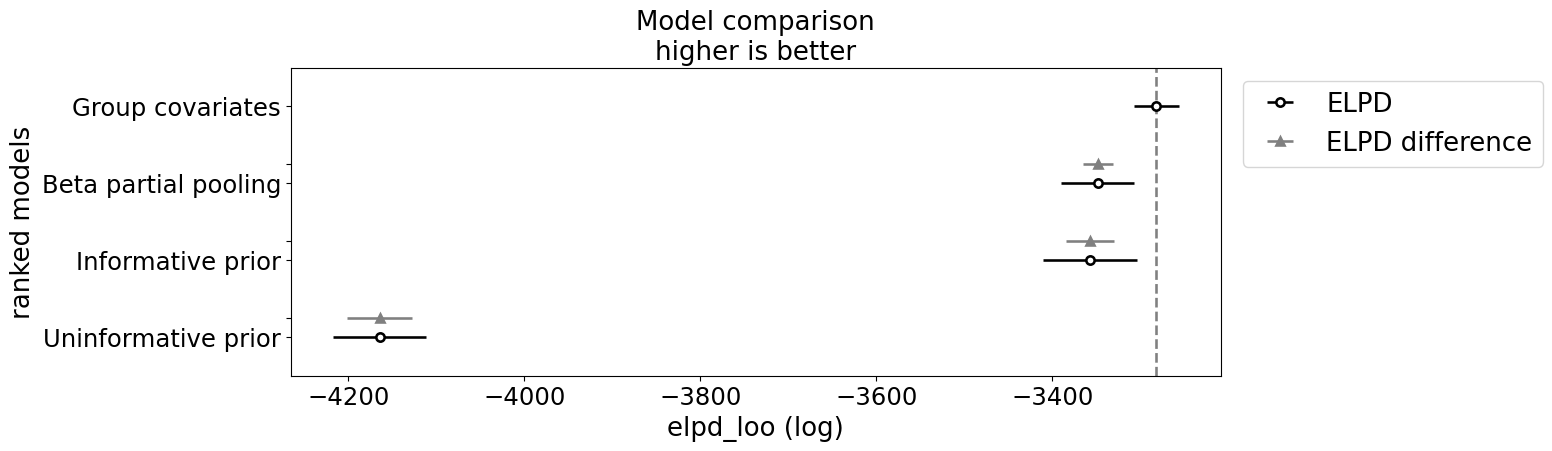

In [49]:
model_compare = az.compare(
    {
        "Uninformative prior": uninformed_prior_trace,
        "Informative prior": informed_prior_trace,
        "Beta partial pooling": beta_partial_pooling_trace,
        "Group covariates": team_trace
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False);

In [50]:
model_compare.round(2)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Group covariates,0,-3281.91,483.57,0.00,1.0,25.54,0.00,True,log
Beta partial pooling,1,-3347.96,614.60,66.06,0.0,41.52,16.66,True,log
Informative prior,2,-3356.68,710.73,74.77,0.0,53.35,27.27,True,log
Uninformative prior,3,-4164.64,1441.25,882.74,0.0,52.86,36.94,True,log


## Individual covariate model

We have expanded our multilevel model to include a group-level factor--position--where every member of the group share an expected value. However, its possible to include covariates at **multiple levels**, provided that they exist. 

Let's go ahead and add some individual covariates: average exit velocity and launch angle.

This might look like this:

$$\text{logit}(p_i) \sim N(\theta_i + X_i\beta, \sigma^2)$$

where again the group mean $\theta$ is:

$$\theta_i = \mu_{j[i]} + \epsilon_{i}$$

and $x_i$ is the average exit velocity for batter $i$.

In [51]:
la_ev = fitting_subset.select(pl.col(["launch_angle", "exit_velo"]))

X = fitting_subset.with_columns((pl.col(["launch_angle", "exit_velo"]) - pl.col(["launch_angle", "exit_velo"]).mean()) / pl.col(["launch_angle", "exit_velo"]).std()).select(pl.col(["launch_angle", "exit_velo"])).to_numpy()

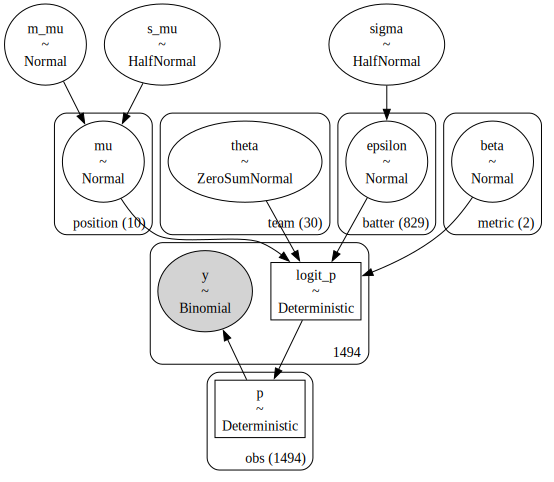

In [52]:
coords['metric'] = 'launch angle', 'exit velo'

with pm.Model(coords=coords) as individual_covariate_model:

    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    mu = pm.Normal('mu', mu=m_mu, sigma=s_mu, dims='position')

    theta = pm.ZeroSumNormal('theta', sigma=1, dims='team')

    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims='batter')

    beta = pm.Normal('beta', mu=0, sigma=1, dims='metric')

    logit_p = pm.Deterministic('logit_p',
        mu[position_idx] + theta[team_idx] + epsilon[batter_idx] + beta.dot(X.T),
    )

    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims='obs')

    y = pm.Binomial('y', n=pa, p=p, observed=hr)

pm.model_to_graphviz(individual_covariate_model)

In [53]:
with individual_covariate_model:
    individual_covariate_trace = pm.sample(1000, tune=2000, chains=2,  nuts_sampler='numpyro', random_seed=RANDOM_SEED)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


As you would expect, the coefficient for average EV is positive, and it soaks up some of the variation that was previously attributed to positional means.

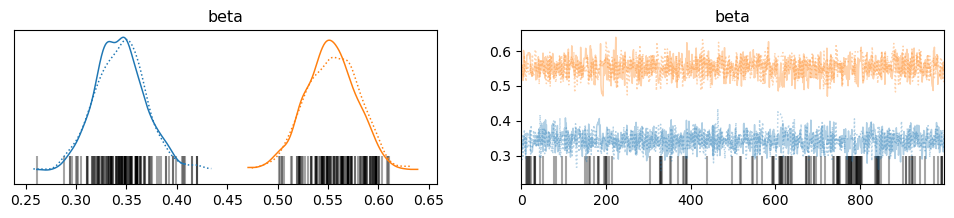

In [54]:
az.plot_trace(individual_covariate_trace, var_names=['beta']);

### Bad Energy?

Another useful diagostic is to compare the overall distribution of 
energy levels with the *change* of energy between successive samples. Ideally, they should be very similar.

If the distribution of energy transitions is narrow relative to the marginal energy distribution, this is a sign of inefficient sampling, as many transitions are required to completely explore the posterior. On the other hand, if the energy transition distribution is similar to that of the marginal energy, this is evidence of efficient sampling, resulting in near-independent samples from the posterior.

These quantities can be readily plotted, using the `energy` values in the model trace:

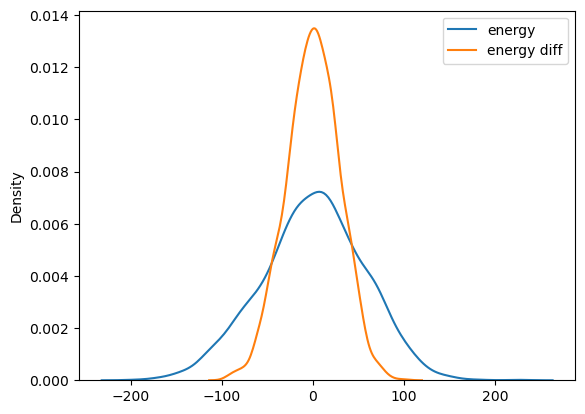

In [55]:
energy = individual_covariate_trace.sample_stats['energy'].values.ravel()
energy_diff = np.diff(energy)
sns.kdeplot(energy - energy.mean(), label='energy')
sns.kdeplot(energy_diff, label='energy diff')
plt.legend();

This is automated via the `plot_energy` function in ArviZ.

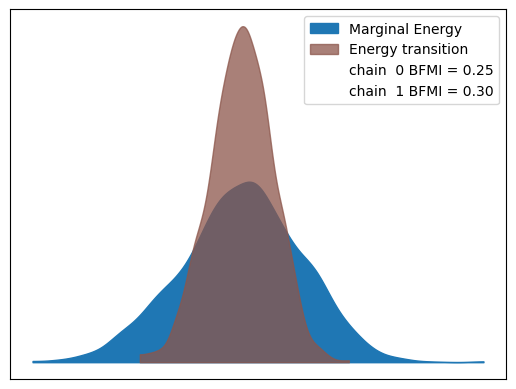

In [56]:
az.plot_energy(individual_covariate_trace);

### Bayesian Fraction of Missing Information

The Bayesian fraction of missing information (BFMI) is a measure of how hard it is to
sample level sets of the posterior at each iteration. Specifically, it quantifies **how well momentum resampling matches the marginal energy distribution**. 

$$\text{BFMI} = \frac{\mathbb{E}_{\pi}[\text{Var}_{\pi_{E|q}}(E|q)]}{\text{Var}_{\pi_{E}}(E)}$$

$$\widehat{\text{BFMI}} = \frac{\sum_{i=1}^N (E_n - E_{n-1})^2}{\sum_{i=1}^N (E_n - \bar{E})^2}$$

A small value indicates that the adaptation phase of the sampler was unsuccessful, and invoking the central limit theorem may not be valid. It indicates whether the sampler is able to *efficiently* explore the posterior distribution.

Though there is not an established rule of thumb for an adequate threshold, values close to one are optimal.

### Diagnosing Divergent Samples

Divergent samples are a warning sign that the MCMC sampler is having trouble exploring the posterior distribution. In particular, they are a sign that the sampler is having trouble negotiating the geometry of the model's posterior distribution. While MCMC algorithms are guaranteed to converge to the correct posterior distribution, and will do so quickly provided that geometric ergodicity conditions are met.

Unfortunately, proving geometric ergodicity is infeasible for most models. Instead we must rely on empirical diagnostics that identify obstructions to geometric ergodicity, and hence well-behaved MCMC estimators. Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore.

A few randomly-occurring divergences are generally not worth worrying about. However, if the number of divergences is large, or if they are concentrated in a particular region of parameter space, then it is likely that the sampler is not exploring the posterior distribution adequately. 

Let's take a closer look at the location of some of the divergent samples in our model.

The ArviZ `plot_parallel` generates a coordinate plot of selected variables that highlight divergent samples. This allows us to detect patterns in the divergences, if any.

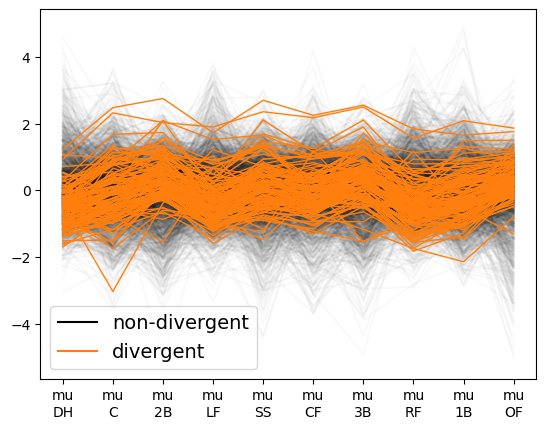

In [57]:
az.plot_parallel(individual_covariate_trace, var_names=["mu"], norm_method="normal");

Divergences frequently pop up in hierarchical models, where the the distrbution of individual random effects changes sharply as the variance of the random effect changes. 

When the random effect variance is small, this implies that the individual random means are themselves close to the population mean. This results in a *funnel*-shaped relationship between the samples of group variance and any of the slopes (particularly those with a smaller sample size). 

In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of `s_mu` is sampled poorly. The result of this will be **biased inference**.

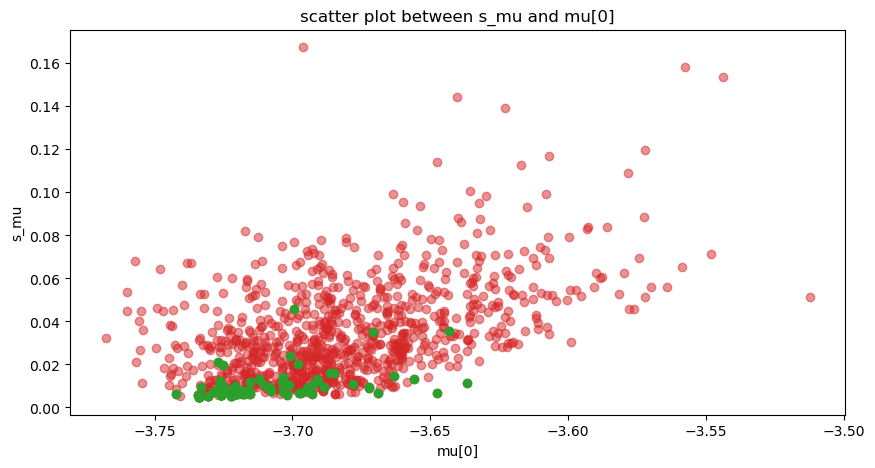

In [58]:
def pairplot_divergence(trace, ax=None, divergence=True, color="C3", divergence_color="C2", chain=1):
    mu = individual_covariate_trace.posterior.sel(chain=chain).mu[:, 0]
    s_mu = individual_covariate_trace.posterior.sel(chain=1).s_mu
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(mu, s_mu, "o", color=color, alpha=0.5)
    if divergence:
        divergent = trace.sample_stats["diverging"][chain]
        ax.plot(mu[divergent], s_mu[divergent], "o", color=divergence_color)
    ax.set_xlabel("mu[0]")
    ax.set_ylabel("s_mu")
    ax.set_title("scatter plot between s_mu and mu[0]")
    return ax

pairplot_divergence(individual_covariate_trace);

## Dealing with Divergences

Having identified the divergent samples, we can now take steps to deal with them. It may be the case that the MCMC sampler simply had not completed tuning when the specified number of `tune` samples were complete. If true, we can just bump up the number of tuning samples and re-run the sampler.

```python
trace = pm.sample(tune=3000)
```

Alternatively, it is possible to force the sampler to do a better job of simulating Hamiltonian dynamics. The simulation necessarily discretizes a continuous trajectory, and the size of the discrete steps determines how close to continuous the simulation is. However, very small step sizes is computationally intensive and does not always measurably improve the quality of the simulation. We can indirectly control the step size by setting the `target_accept` argument; values closer to one will result in smoother trajectories. The default value in PyMC is 0.8, so bumping this to 0.9 or larger may help.

```python
trace = pm.sample(target_accept=0.95)
```

If this does not work, we can try to **reparameterize** the model. This is a general strategy for improving the geometry of the posterior distribution, and is especially useful for hierarchical models.

The random effect is specified in a centered parameterization, where the random effect is centered on the group mean. This is a natural way to specify the model, but it can result in the behavior we are seeing.

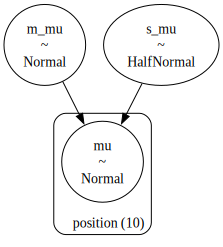

In [59]:
with pm.Model(coords=coords) as centered_re:

    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    mu = pm.Normal('mu', mu=m_mu, sigma=s_mu, dims='position')

pm.model_to_graphviz(centered_re)

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on `m_mu`. Instead, they are independent standard normals `z`, which are then scaled by the appropriate value of `s_mu`, before being location-transformed by the mean.

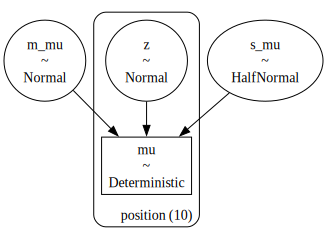

In [60]:
with pm.Model(coords=coords) as noncentered_re:
    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    z = pm.Normal('z', mu=0, sigma=1, dims='position')
    mu = pm.Deterministic('mu', m_mu + s_mu * z, dims='position')

pm.model_to_graphviz(noncentered_re)

This model samples much better.

In [61]:
with pm.Model(coords=coords) as noncentered_individual_covariate_model:

    # Non-centered random effect!
    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    z = pm.Normal('z', mu=0, sigma=1, dims='position')
    mu = pm.Deterministic('mu', m_mu + s_mu * z, dims='position')

    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims='batter')

    theta = pm.ZeroSumNormal('theta', sigma=1, dims='team')

    beta = pm.Normal('beta', mu=0, sigma=1, dims='metric')

    logit_p = pm.Deterministic('logit_p',
        mu[position_idx] + theta[team_idx] + epsilon[batter_idx] + beta.dot(X.T),
    )

    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims='obs')

    y = pm.Binomial('y', n=pa, p=p, observed=hr)

    noncentered_individual_covariate_trace = pm.sample(1000, tune=2000, nuts_sampler='numpyro', random_seed=RANDOM_SEED)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


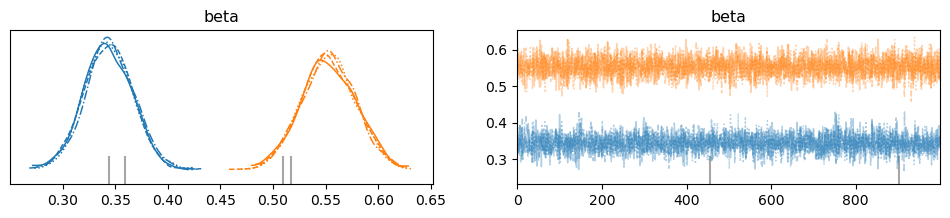

In [62]:
az.plot_trace(noncentered_individual_covariate_trace, var_names=['beta']);

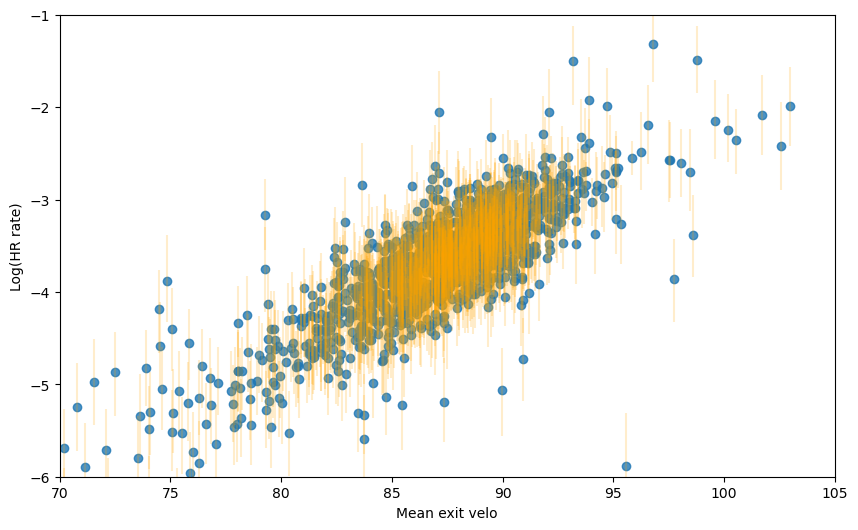

In [63]:
ev = fitting_subset.select(pl.col("exit_velo")).to_numpy().squeeze()
post = noncentered_individual_covariate_trace.posterior.assign_coords(ev=ev)
avg_p = post["logit_p"].mean(dim=("chain", "draw")).values[np.argsort(ev)]
avg_p_hdi = az.hdi(post, var_names="logit_p")["logit_p"]

_, ax = plt.subplots(figsize=(10,6))
ax.vlines(
    ev,
    avg_p_hdi.sel(hdi="lower"),
    avg_p_hdi.sel(hdi="higher"),
    alpha=0.2,
    color="orange",
)
ax.scatter(ev[np.argsort(ev)], avg_p, alpha=0.8)

plt.xlim(70,105)
plt.ylim(-6, -1)
plt.xlabel("Mean exit velo")
plt.ylabel("Log(HR rate)");

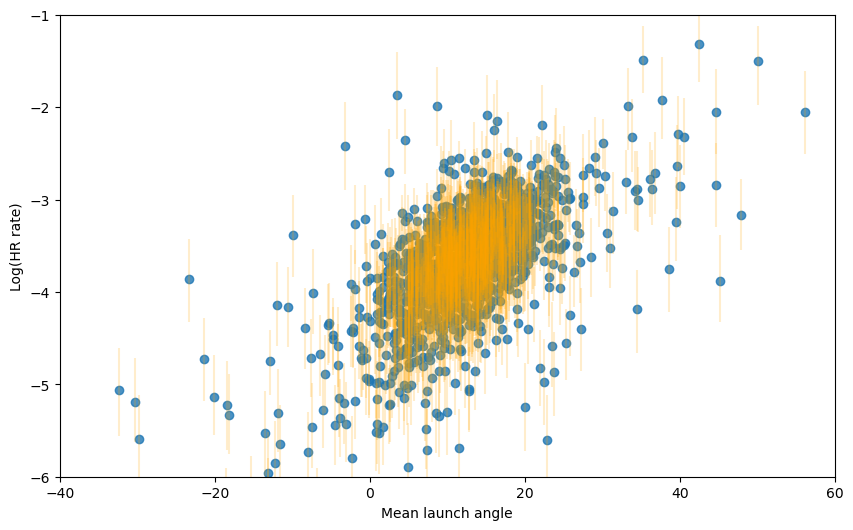

In [64]:
ev = fitting_subset.select(pl.col("launch_angle")).to_numpy().squeeze()
post = noncentered_individual_covariate_trace.posterior.assign_coords(ev=ev)
avg_p = post["logit_p"].mean(dim=("chain", "draw")).values[np.argsort(ev)]
avg_p_hdi = az.hdi(post, var_names="logit_p")["logit_p"]

_, ax = plt.subplots(figsize=(10,6))
ax.vlines(
    ev,
    avg_p_hdi.sel(hdi="lower"),
    avg_p_hdi.sel(hdi="higher"),
    alpha=0.2,
    color="orange",
)
ax.scatter(ev[np.argsort(ev)], avg_p, alpha=0.8)

plt.xlim(-40,60)
plt.ylim(-6, -1)
plt.xlabel("Mean launch angle")
plt.ylabel("Log(HR rate)");

If we just look at the subset of hierarchical models we have fit so far, adding individual covariates was an important model expansion step, resulting in more precise predictions.

Output()

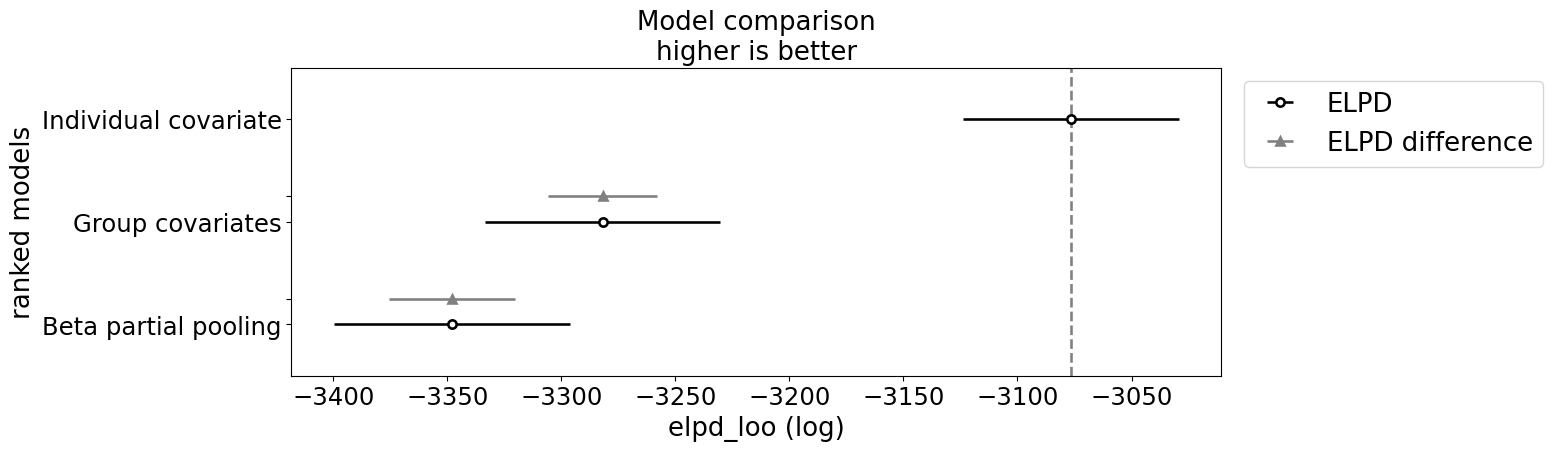

In [65]:
with noncentered_individual_covariate_model:
    pm.compute_log_likelihood(noncentered_individual_covariate_trace)

model_compare = az.compare(
    {
        "Beta partial pooling": beta_partial_pooling_trace,
        "Group covariates": team_trace,
        "Individual covariate": noncentered_individual_covariate_trace
    }
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False);

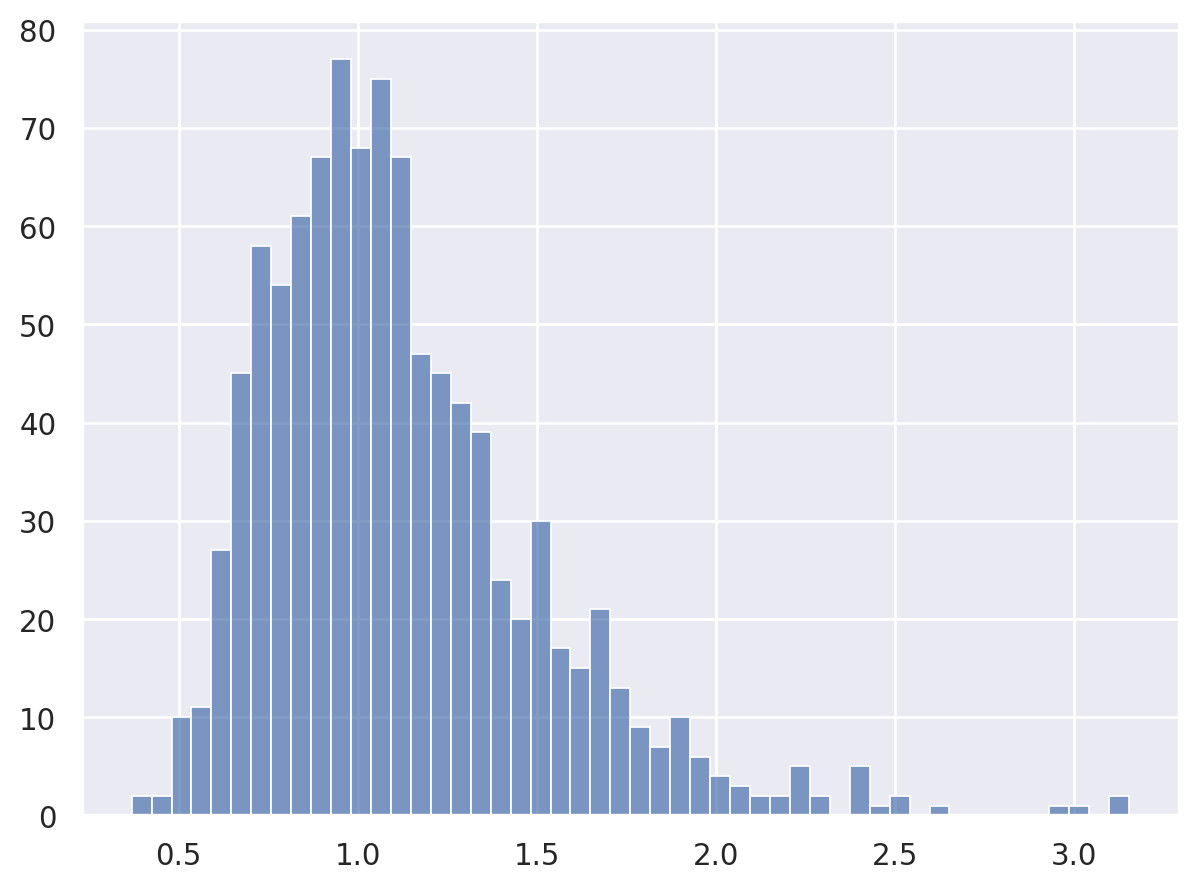

In [66]:
so.Plot(pm.draw(pm.InverseGamma.dist(10, 10), 1000)).add(so.Bars(), so.Hist(bins=50))

In [67]:
with pm.Model(coords=coords) as gp_covariate_model:

    # Non-centered random effect!
    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    z = pm.Normal('z', mu=0, sigma=1, dims='position')
    mu = pm.Deterministic('mu', m_mu + s_mu * z, dims='position')

    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims='batter')

    eta = pm.Exponential("eta", lam=1)

    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=0.5, upper=4, 
        init_guess={"alpha": 10, "beta": 10},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    cov = eta**2 * pm.gp.cov.Matern52(2, ls=ell)
    gp = pm.gp.HSGP(m=[50, 50], c=2.0, mean_func=pm.gp.mean.Constant(-3), cov_func=cov)
    contact_quality = gp.prior("contact_quality", X=X)

    logit_p = pm.Deterministic('logit_p',
        mu[position_idx] + epsilon[batter_idx] + contact_quality,
    )

    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims='obs')

    y = pm.Binomial('y', n=pa, p=p, observed=hr)

    gp_covariate_trace = pm.sample(1000, tune=1000, chains=2, nuts_sampler='numpyro', nuts_sampler_kwargs={'chain_method': 'parallel'}, random_seed=RANDOM_SEED)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [68]:
x1new = np.linspace(-3, 3, 25)[:, None]
x2new = np.linspace(-3, 3, 25)[:, None]
Xnew = pm.math.cartesian(x1new, x2new)
x1new.shape, x2new.shape, Xnew.shape

((25, 1), (25, 1), (625, 2))

In [90]:
with gp_covariate_model:
    contact_quality_grid = gp.conditional("contact_quality_grid", Xnew)

    ppc = pm.sample_posterior_predictive(gp_covariate_trace, var_names=["contact_quality_grid"])

Sampling: []


Output()

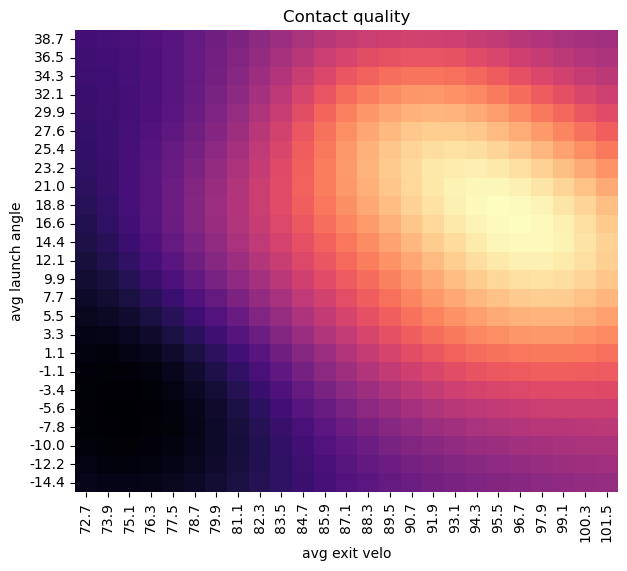

In [133]:
fig, ax = plt.subplots(figsize=(7, 6))

ev_la = fitting_subset.select(pl.col(["exit_velo", "launch_angle"]))
X_rev = (np.array([x[::-1] for x in Xnew]) * ev_la.std() + ev_la.mean()).round(1)

plot_df = pd.DataFrame(np.c_[X_rev, np.mean(ppc.posterior_predictive["contact_quality_grid"].sel(chain=0), axis=0)], columns=("avg exit velo", "avg launch angle", "contact quality"))

sns.heatmap(plot_df.pivot(columns="avg exit velo", index="avg launch angle", values="contact quality").sort_index(ascending=False), cmap="magma", cbar=False, ax=ax)
ax.set_title("Contact quality");

Output()

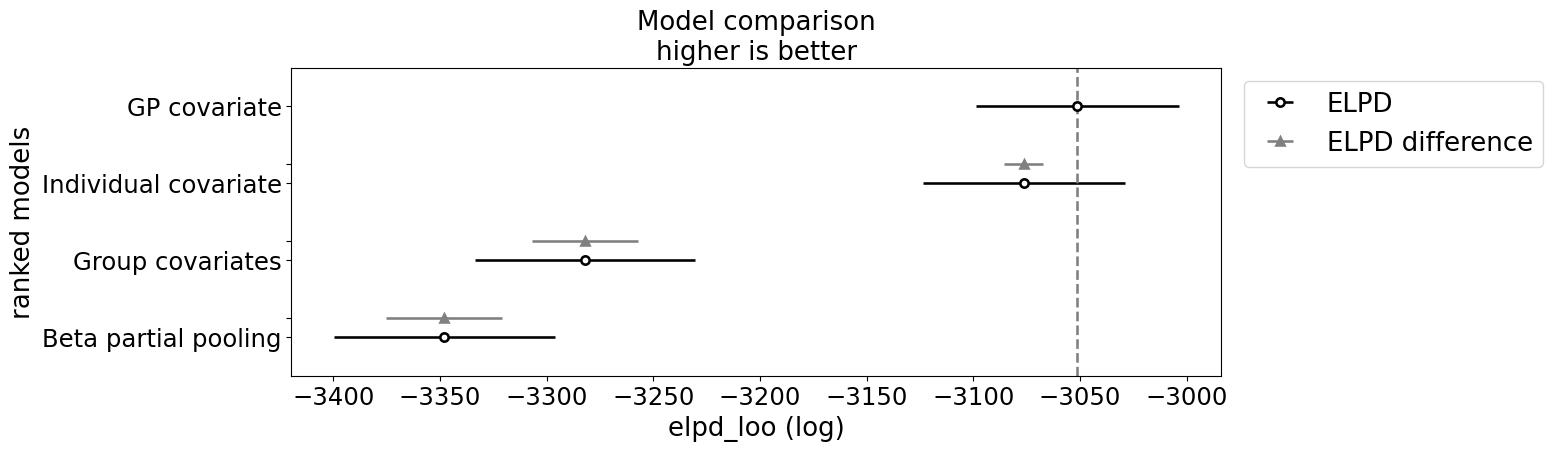

In [71]:
with gp_covariate_model:
    pm.compute_log_likelihood(gp_covariate_trace)

model_compare = az.compare(
    {
        "Beta partial pooling": beta_partial_pooling_trace,
        "Group covariates": team_trace,
        "Individual covariate": noncentered_individual_covariate_trace,
        "GP covariate": gp_covariate_trace
    }
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False);

## Out-of-sample prediction

In many cases you want to predict on unseen (hold-out) data. PyMC includes a `pm.Data` container to help with this. It is a wrapper around a `pytensor.shared` variable and allows the values of the data to be changed later. Otherwise, `pm.Data` objects can be used just like any other numpy array or tensor.

This distinction is significant, since internally all models in PyMC are giant symbolic expressions. When you pass raw data directly into a model, you are giving PyTensor permission to treat this data as a constant and optimize it away if doing so makes sense. If you need to change this data later you may not have any way to point at it within the larger symbolic expression. Using `pm.Data` offers a way to point to a specific place in the symbolic expression and change what is there.

Let's update the last model to use `pm.Data`:

In [72]:
with pm.Model(coords=coords) as noncentered_individual_covariate_model:

    X_data = pm.Data('X_data', X)
    pa_data = pm.Data('pa_data', pa)
    hr_data = pm.Data('hr_data', hr)
    position_ind = pm.Data('position_idx', position_idx.astype(int))
    batter_ind = pm.Data('batter_idx', batter_idx.astype(int))
    team_ind = pm.Data('team_idx', team_idx.astype(int))

The rest of the model remains unchanged, other than perhaps some data variable renaming.

In [73]:
with noncentered_individual_covariate_model:

    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    z = pm.Normal('z', mu=0, sigma=1, dims='position')
    mu = pm.Deterministic('mu', m_mu + s_mu * z, dims='position')

    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims='batter')

    beta = pm.Normal('beta', mu=0, sigma=1, dims='metric')

    theta = pm.ZeroSumNormal('theta', sigma=1, dims='team')

    logit_p = pm.Deterministic('logit_p',
        mu[position_ind] + theta[team_ind] + epsilon[batter_ind] + beta.dot(X_data.T),
    )

    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims='obs')

    y = pm.Binomial('y', n=pa_data, p=p, observed=hr_data)

    noncentered_individual_covariate_trace = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_mu, s_mu, z, sigma, epsilon, beta, theta]
/home/cfonnesbeck/miniforge3/envs/pymc_course/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/home/cfonnesbeck/miniforge3/envs/pymc_course/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 27 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Let's use the 2023 data to-date as the holdout set.

In [74]:
predict_subset = baseball_data.filter(pl.col("season") == 2023).with_columns(
    pl.concat_str([
        pl.col("name"),
        pl.col("season"),
        pl.col("team")
    ], separator=" - ").alias("label")
).drop_nulls()

Because of the structure of our model, we have a bit of a bookkeeping challenge on our hands. The prediction data contains some players that were not part of the training data from the preceeding years. Since we have random effects in our model, we need to take care that the estimated random effects are associated with the same players in the prediction data.

Let's start by identifying the players that we have seen before and those that are new. We can use Python's set operations to do this.

In [75]:
existing_batters = set(fitting_subset.select(pl.col('id')).to_numpy().squeeze()).intersection(predict_subset.select(pl.col('id')).to_numpy().squeeze())
len(existing_batters)

477

In [76]:
new_batters = set(predict_subset.select(pl.col('id')).to_numpy().squeeze()).difference(set(fitting_subset.select(pl.col('id')).to_numpy().squeeze()))
len(new_batters)

34

Having these two distinct sets, we can go about extracting the associated data.

In [77]:
existing_batter_df = predict_subset.filter(pl.col("id").is_in(existing_batters)).with_columns((pl.col(["launch_angle", "exit_velo"]) - pl.col(["launch_angle", "exit_velo"]).mean()) / pl.col(["launch_angle", "exit_velo"]).std()).select(pl.col(["name", "label", "position", "team","launch_angle", "exit_velo", "num_pa", "hr"]))

existing_batter_df.shape

(479, 8)

For the players from the fitting subset, we can use the `pm.set_data` function to replace the values in each of the `pm.MutableData` objects with the new values. 

Getting the correct index values for the random effects is the key, which I've done using a list comprehension.

In [78]:
with noncentered_individual_covariate_model:

    pm.set_data({
        "X_data": existing_batter_df.select(pl.col(['launch_angle', 'exit_velo'])).to_numpy(),
        "pa_data": existing_batter_df.select(pl.col("num_pa")).to_numpy().squeeze(),
        "hr_data": existing_batter_df.select(pl.col("hr")).to_numpy().squeeze(),
        "position_idx": [np.where(positions==name)[0].item() for name in existing_batter_df.select(pl.col("position")).to_numpy().squeeze()],
        "batter_idx": [np.where(batters==name)[0].item() for name in existing_batter_df.select(pl.col("name")).to_numpy().squeeze()],
        "team_idx": [int(np.where(teams==name)[0].item()) for name in existing_batter_df.select(pl.col("team")).to_numpy().squeeze()],
    })

As for the previously-unseen batters, we create a similar dataset, but instead of retrieving indices from the fit model, we just create a new set of unique indices.

In [79]:
new_batter_df = (predict_subset
    .filter(pl.col("id").is_in(new_batters))
    .with_columns((pl.col(["launch_angle", "exit_velo"]) - pl.col(["launch_angle", "exit_velo"]).mean()) / pl.col(["launch_angle", "exit_velo"]).std())
    .select(["id", "name", "label", "position", "team", "exit_velo", "launch_angle", "num_pa", "hr"])
)

In [80]:
with noncentered_individual_covariate_model:
    ppc = pm.sample_posterior_predictive(noncentered_individual_covariate_trace)

Sampling: [y]


Output()

In [81]:
new_position_idx = (new_batter_df
    .with_columns(pl.col("position").replace(dict(zip(positions, np.arange(len(positions))))).cast(int).alias("position_idx"))
    .select(pl.col("position_idx"))
    .to_numpy().squeeze()
)
new_team_idx = (new_batter_df
    .with_columns(pl.col("team").replace(dict(zip(teams, np.arange(len(teams))))).cast(int).alias("team_idx"))
    .select(pl.col("team_idx"))
    .to_numpy().squeeze()
)
new_X = new_batter_df.select(pl.col(["launch_angle", "exit_velo"])).to_numpy()
new_hr = new_batter_df.select(pl.col("hr")).to_numpy().squeeze()
new_pa = new_batter_df.select(pl.col("num_pa")).to_numpy().squeeze()
new_batter_idx, new_batters = factorize(new_batter_df, "name")

For these new players, we add additional variables to the model. Specifically, we want to draw additional random effects for them from the fitted distribution.

These, in turn, can be fed to the downstream variables, each with a variable name that is unique to the set of new players.

In [82]:
with noncentered_individual_covariate_model:

    noncentered_individual_covariate_model.add_coord('batter_new', new_batters)

    epsilon_new = pm.Normal('epsilon_new', mu=0, sigma=sigma, shape=len(new_batters))

    logit_p_new = pm.Deterministic('logit_p_new',
        mu[new_position_idx] + theta[new_team_idx] + epsilon_new[new_batter_idx] + beta.dot(new_X.T),
    )

    p_new = pm.Deterministic('p_new', pm.math.invlogit(logit_p_new))

    y_new = pm.Binomial('y_new', n=new_pa, p=p_new, observed=new_hr, dims='batter_new')

Its worth taking a look at the model DAG, just to see if everything makes sense.

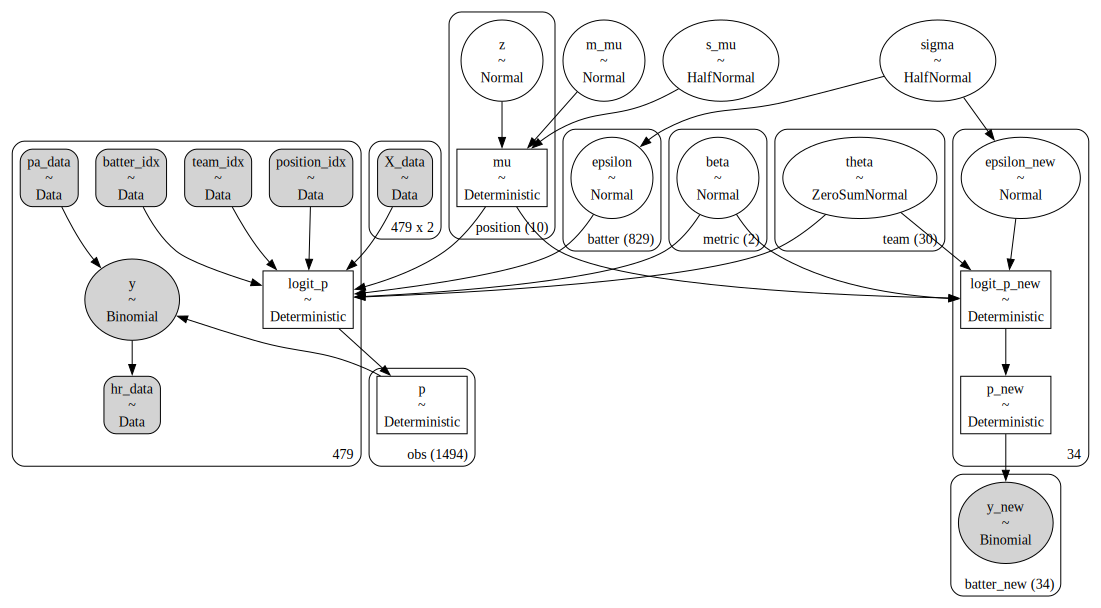

In [83]:
pm.model_to_graphviz(noncentered_individual_covariate_model)

Then, it's just a matter of sampling from the posterior predictive distribution.

Sampling: [epsilon_new, y, y_new]


Output()

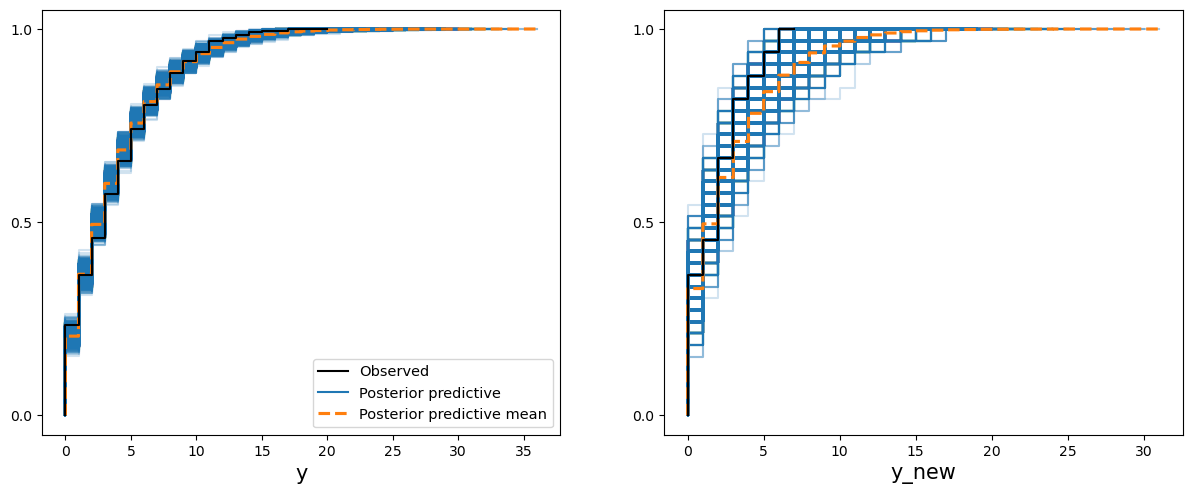

In [84]:
with noncentered_individual_covariate_model:
    ppc_indiv = pm.sample_posterior_predictive(noncentered_individual_covariate_trace)

az.plot_ppc(ppc_indiv, kind='cumulative');

The fit looks good -- below are the posterior predictive distributions for the new players, and the number of home runs they have hit so far this season (red vertical lines).

In [85]:
included_batters = ppc_indiv.posterior_predictive['y_new'].coords['batter_new'][14:20].values

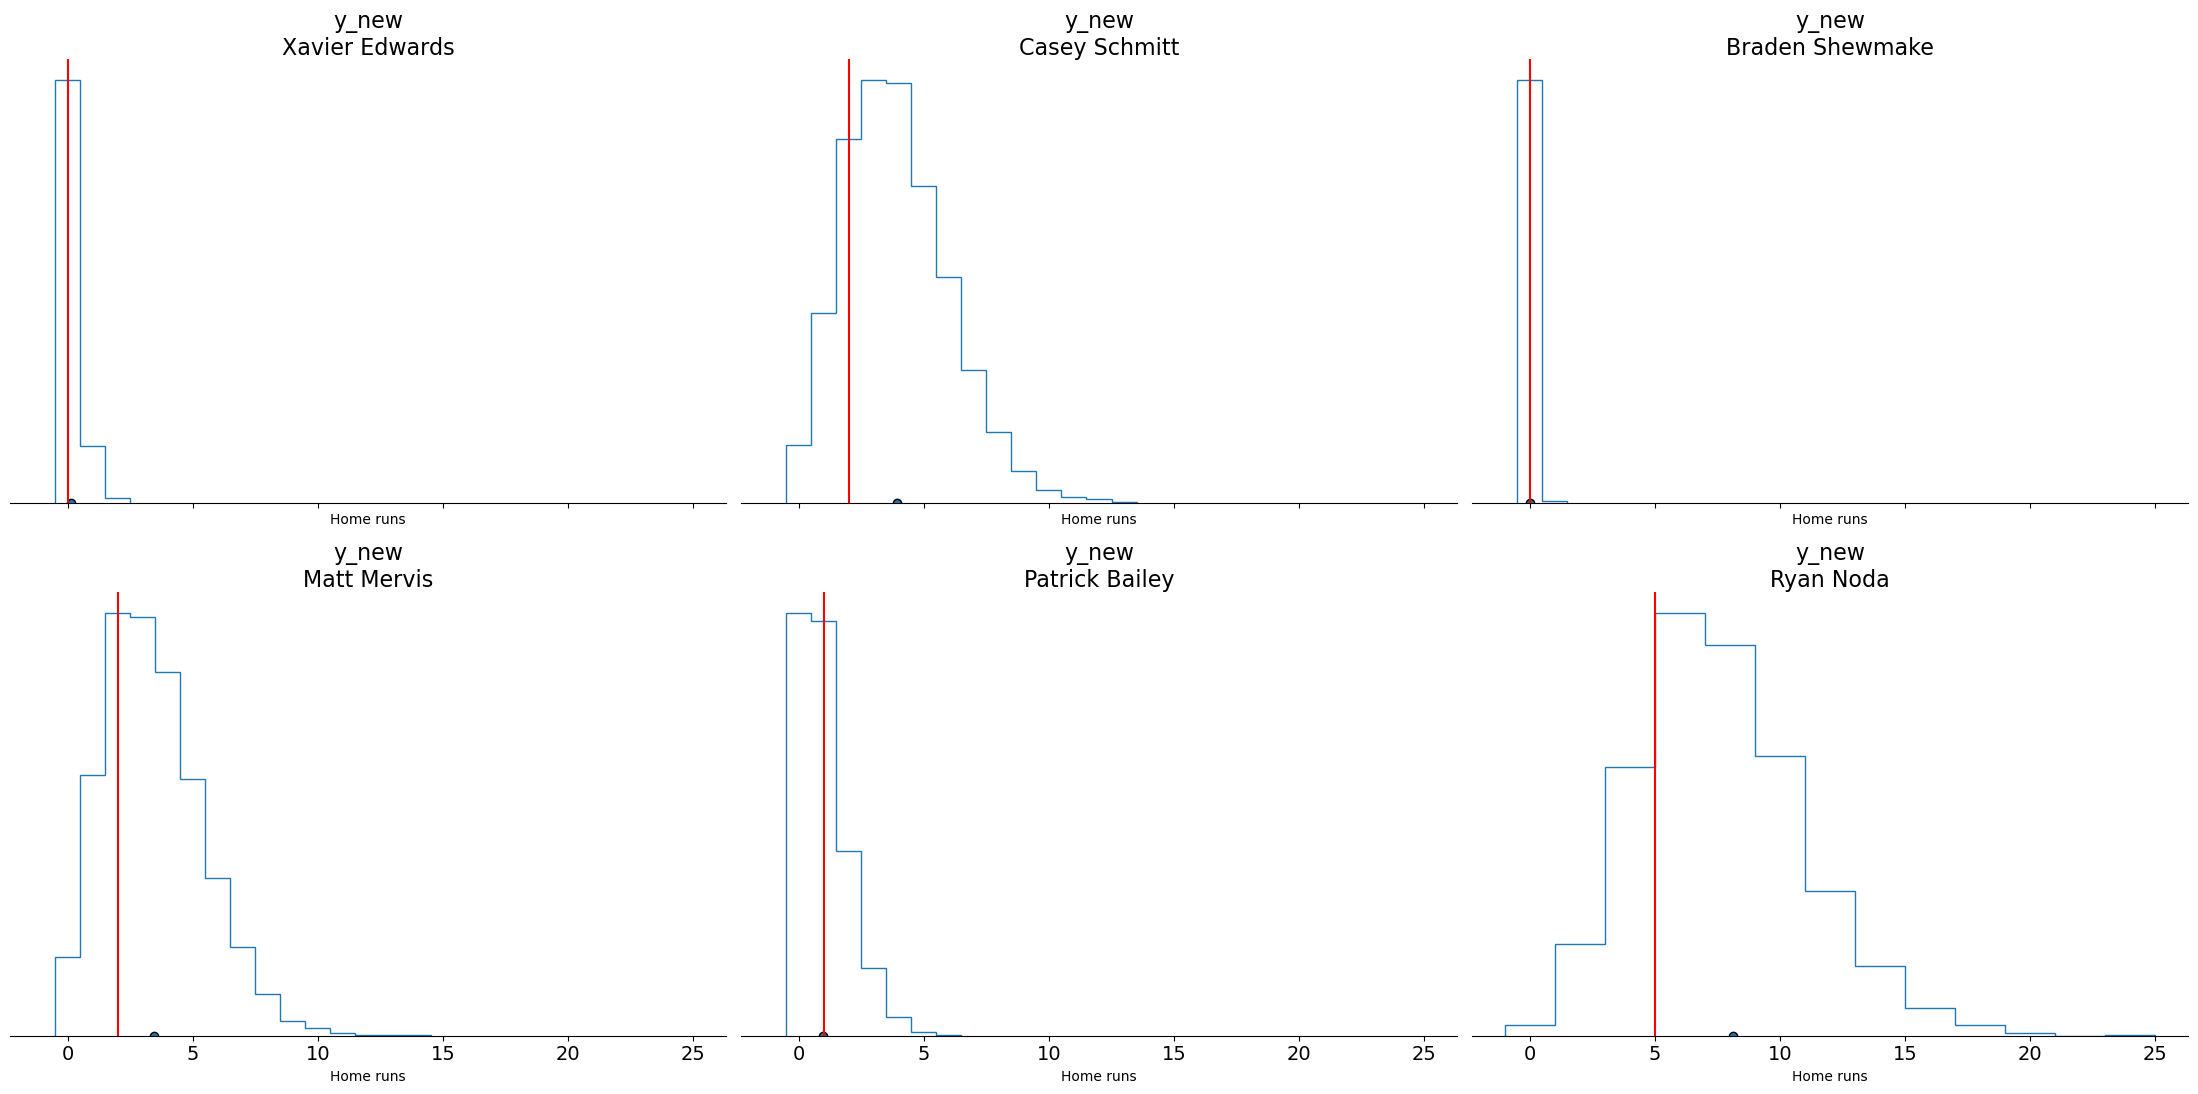

In [86]:
axes = az.plot_density(ppc_indiv.posterior_predictive['y_new'].sel(batter_new=included_batters), backend_kwargs={'sharex': True})
for a,hr in zip(axes.flat, new_hr[14:20]):
    a.axvline(hr, 0, 10, color="red")
    a.set_xlabel("Home runs")
plt.tight_layout()

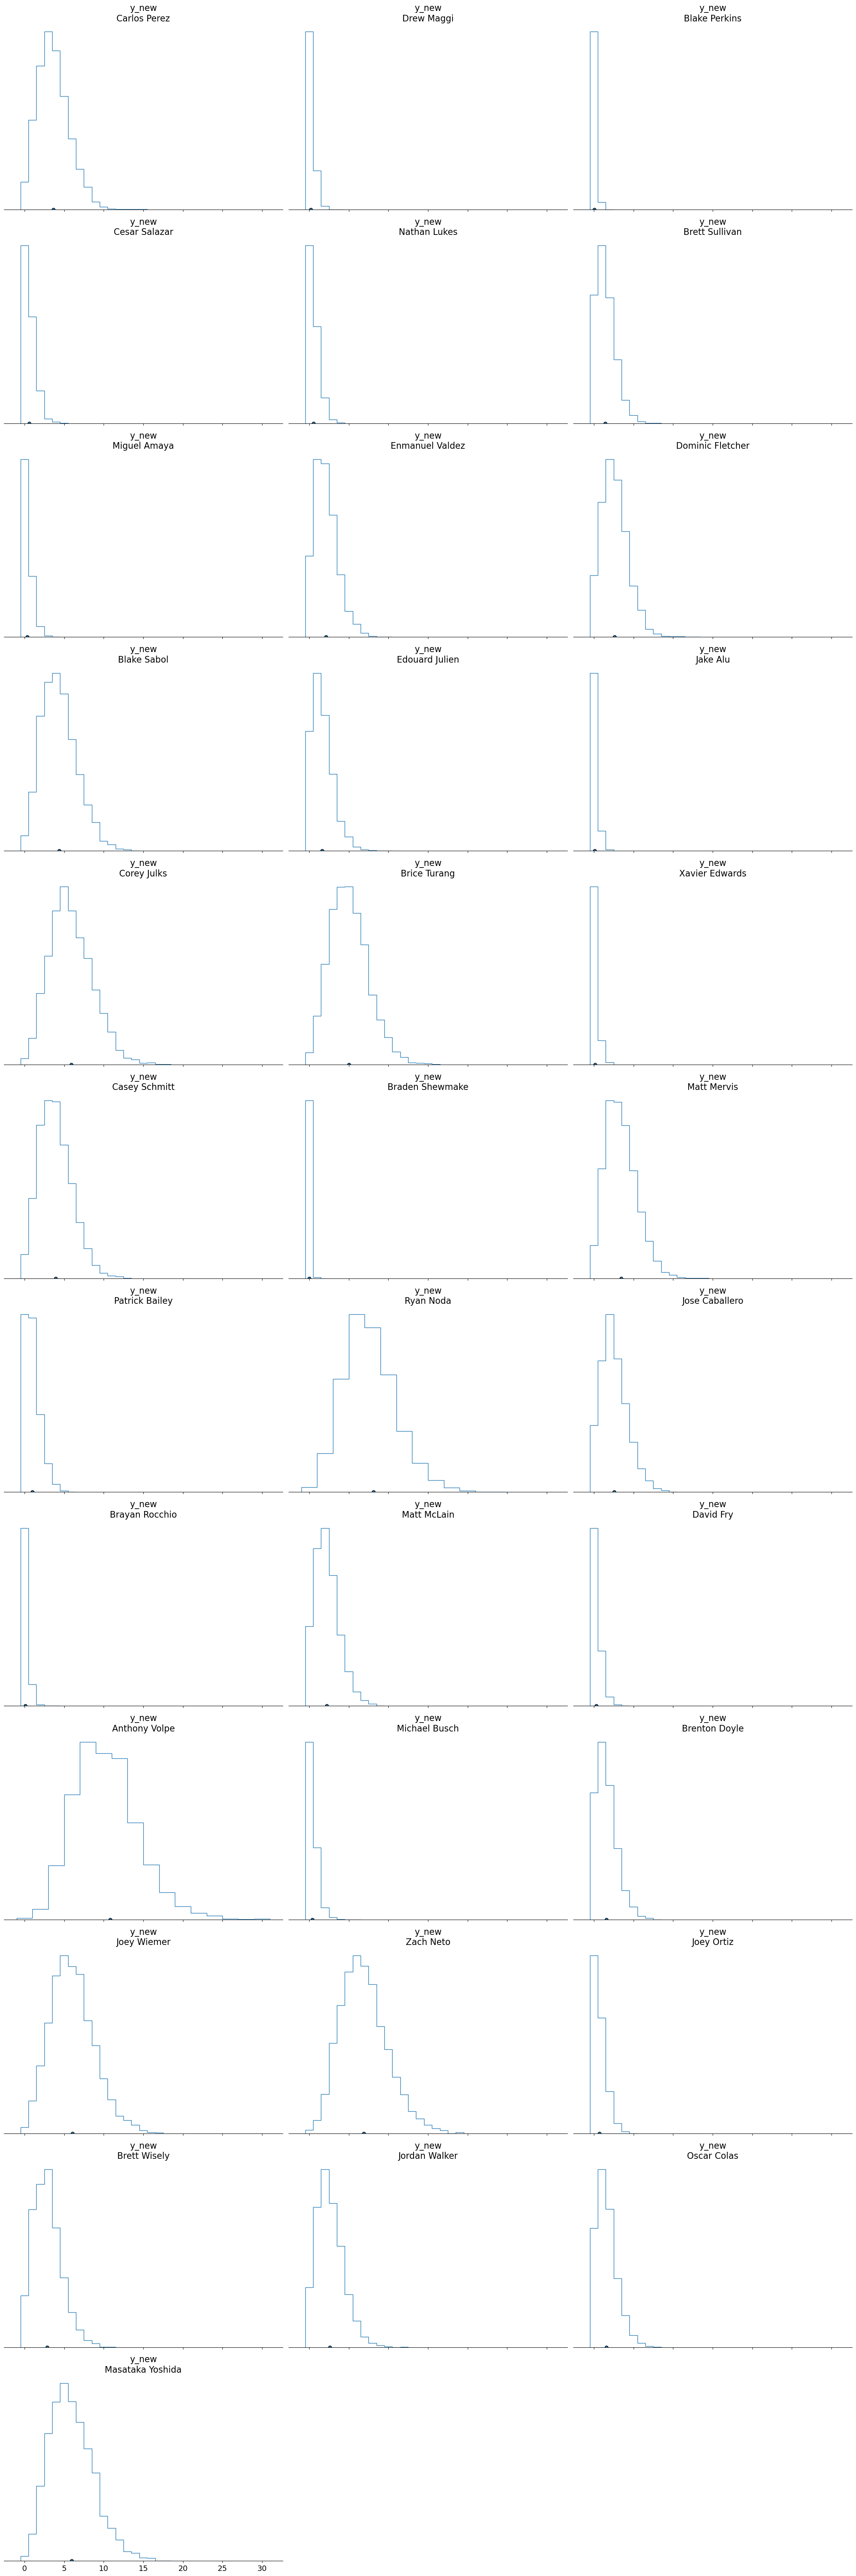

In [87]:
axes_ppc = az.plot_density(ppc_indiv, group='posterior_predictive', var_names=["y_new"], backend_kwargs={'sharex': True})
for a, hr in zip(axes.flat, new_hr):
    a.axvline(hr, 0, 10, color="red")
plt.tight_layout()

## Workflow Steps

1. Data visualization
2. Build provisional model
3. Prior predictive checks
4. Fit model
5. Assess convergence
6. Posterior predictive checks
7. Improve model
8. GOTO 5